In [ ]:
#Importing time package and starting the timer to track duration of execution
import time
start_time = time.time()
#Required Installations
!pip install pycld2 #For language detection
!pip install contractions #For EDA on text cleaning (couldn't -> could not)
!pip install gensim #For sentence length detection with gensim tokenizer
!pip install sacrebleu #For evaluation of model translated predictions
!pip install -q -U keras-tuner #For picking the optimal set of parameters to build models

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
#Required Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')
import random
import keras
from keras.utils import to_categorical
from keras import models
from keras import layers
from keras import callbacks
from keras.datasets import imdb
from keras.engine.sequential import input_layer
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Concatenate
from keras.models import load_model
from keras.layers import RepeatVector
from keras import optimizers
from keras.preprocessing import image
from keras.regularizers import l2
import keras_tuner as kt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D, BatchNormalization
from tensorflow.keras.layers import Dropout, MaxPooling1D, Bidirectional, Conv1D, SimpleRNN, Dropout, Flatten
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve, plot_precision_recall_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from google.colab import drive
drive.mount('/content/drive')
import nltk
from nltk.corpus import stopwords
from nltk.translate import meteor, meteor_score
from nltk import word_tokenize
from wordcloud import WordCloud,STOPWORDS
from textblob import Word
import re
import regex
import pycld2 as cld2
import string
from tqdm.notebook import tqdm
import contractions
import spacy
from gensim.utils import tokenize
from IPython.core.interactiveshell import validate
from IPython.display import Image
from plotly.subplots import make_subplots
import plotly.graph_objects as go
tqdm.pandas()
from pickle import dump, load
import PIL
from PIL import Image
import cv2
from sacrebleu.metrics import BLEU
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import io
import json
import pickle
from scipy import spatial
from numpy.random import RandomState

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Other required downloads
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

### Importing NewsCommentary dataset into a dataframe, performing primary analysis and taking required actions

In [ ]:
#Downloaded the dataset from 'https://statmt.org/wmt14/training-parallel-nc-v9.tgz' and placed in GDrive
#Reading the english list and saving it as 'nc_english_list'
with open('/content/drive/MyDrive/Learning/news-commentary-v9.de-en.en','r',encoding='utf8') as file:
  nc_english_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from NewsCommentary/English dataset
  print('Number of english sentences in NewsCommentary dataset:',len(nc_english_list))
#Reading the german list and saving it as 'nc_german_list'
with open('/content/drive/MyDrive/Learning/news-commentary-v9.de-en.de','r',encoding='utf8') as file:
  nc_german_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from NewsCommentary/German dataset
  print('Number of german sentences in NewsCommentary dataset:',len(nc_german_list))

Number of english sentences in NewsCommentary dataset: 201995
Number of german sentences in NewsCommentary dataset: 201854


**Observation 1: Sentence count mismatch.**

In [ ]:
#Printing first and last sentences of dataset - Primary analysis on the given dataset
print('First line of English and German list are as below:')
print('-'*50)
print('\nENGLISH: %s\nGERMAN:  %s'%(nc_english_list[0], nc_german_list[0]))
print('\nLast line of English and German list are as below:')
print('-'*50)
print('\nENGLISH: %s\nGERMAN:  %s'%(nc_english_list[-1], nc_german_list[-1]))

First line of English and German list are as below:
--------------------------------------------------

ENGLISH: $10,000 Gold?
GERMAN:  Steigt Gold auf 10.000 Dollar?

Last line of English and German list are as below:
--------------------------------------------------

ENGLISH: Somehow Zuma must find a way to honor his own generation’s commitment to racial justice and national liberation, while empowering the masses who daily suffer the sting of class differences and yearn for material gain.
GERMAN:  Irgendwie muss Zuma einen Weg finden, einerseits das Engagement seiner Generation hinsichtlich ethnischer Gerechtigkeit und nationaler Befreiung zu würdigen und andererseits den Massen, die täglich unter Klassenunterschieden leiden und sich nach materiellen Verbesserungen sehnen, mehr Mitwirkungsmöglichkeiten einzuräumen.


**Observation 2: First and last records are having proper translation correlation.**

In [ ]:
#Displaying the lines of dataset that starts with whitespace
index_range = np.arange(21000, 23000,1)
j = 1
for i in index_range:
  if nc_english_list[i].startswith(' '):
    print('%d: <SoS>%s<EoS>'%(j, nc_english_list[i]))
    j +=1

1: <SoS> de facto<EoS>
2: <SoS> bail-out would be very costly for EMU’s more solid countries, while undermining EMU’s hard-won credibility as an area of stability and fiscal soundness.<EoS>
3: <SoS> th<EoS>
4: <SoS> place to 39<EoS>
5: <SoS> th<EoS>
6: <SoS> .<EoS>
7: <SoS> Azzurri<EoS>
8: <SoS> (the Italian national team, in their blue shirts), led by a manager who, because he was successful in business, is convinced he will be successful at managing the state.<EoS>
9: <SoS> Lega Nord<EoS>
10: <SoS> , declared in a recent interview: "Let's be done with the utopia of privatization.<EoS>
11: <SoS> has<EoS>
12: <SoS> done it has gotten wrong.<EoS>
13: <SoS> Corriere della Sera<EoS>
14: <SoS> , which may become more friendly to Berlusconi with an ownership change approved by him. <EoS>
15: <SoS> Weak public finances<EoS>
16: <SoS> . When Italy joined the European Monetary Union, its primary budget surplus (tax receipts in excess of government spending, excluding interest payments) was abo

In [ ]:
#Function to review records starting with white space and merge it with its original sentences
def merge_sentences_starts_with_space(original_list):
  cleaned_list = []
  for index,value in enumerate(original_list):
    if value.startswith(' '):
      cleaned_list[-1] = cleaned_list[-1] + value
    else:
      cleaned_list.append(value)
  print('Number of records before merging:', len(original_list))
  print('Number of records after merging:', len(cleaned_list))
  return cleaned_list

In [ ]:
print('Printing details for English List')
nc_eng_merged = merge_sentences_starts_with_space(nc_english_list)
print('Printing details for German List')
nc_german_merged = merge_sentences_starts_with_space(nc_german_list)

Printing details for English List
Number of records before merging: 201995
Number of records after merging: 201288
Printing details for German List
Number of records before merging: 201854
Number of records after merging: 201288


In [ ]:
#Creating a dataframe for NewCommentary as number of records for english and german are matching
df_nc = pd.DataFrame(list(zip(nc_german_merged,nc_eng_merged)),columns=('German','English'))
#Printing head to review translation correlation - Primary analysis on the given dataset
df_nc.head()

German  \
0                     Steigt Gold auf 10.000 Dollar?   
1  SAN FRANCISCO – Es war noch nie leicht, ein ra...   
2  In letzter Zeit allerdings ist dies schwierige...   
3  Erst letzten Dezember verfassten meine Kollege...   
4                  Und es kam, wie es kommen musste.   

                                             English  
0                                      $10,000 Gold?  
1  SAN FRANCISCO – It has never been easy to have...  
2  Lately, with gold prices up more than 300% ove...  
3  Just last December, fellow economists Martin F...  
4                              Wouldn’t you know it?

In [ ]:
#Printing tail to review translation correlation - Primary analysis on the given dataset
df_nc.tail()

German  \
201283  Das bleibt eine der größten Errungenschaften i...   
201284  Gleichzeitig scheint sich Zumas revolutionäre ...   
201285  In einer Region, wo die älteren Menschen sehr ...   
201286  Drei von zehn Südafrikanern sind jünger als 15...   
201287  Irgendwie muss Zuma einen Weg finden, einersei...   

                                                  English  
201283  Their achievement remains one of the greatest ...  
201284  At the same time, Zuma’s revolutionary generat...  
201285  In a region that reveres the elderly, Zuma’s a...  
201286  Three in ten South Africans are younger than 1...  
201287  Somehow Zuma must find a way to honor his own ...

#### **Insights and Decision:**
*   Both German and English datasets are now having same number of records and correlation has been verified with head() and tail() methods

### Importing Common Crawl dataset into a dataframe and performing primary analysis

In [ ]:
#Downloaded the dataset from 'https://statmt.org/wmt13/training-parallel-commoncrawl.tgz' and placed in GDrive
#Reading the english list and saving it as 'cc_english_list'
with open('/content/drive/MyDrive/Learning/commoncrawl.de-en.en','r',encoding='utf8') as file:
  cc_english_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from Commoncrawl/English dataset
  print('Number of english sentences in Commoncrawl dataset is:',len(cc_english_list))
#Reading the german list and saving it as 'cc_german_list'
with open('/content/drive/MyDrive/Learning/commoncrawl.de-en.de','r',encoding='utf8') as file:
  cc_german_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from Commoncrawl/German dataset
  print('Number of german sentences in Commoncrawl dataset is:',len(cc_german_list))

Number of english sentences in Commoncrawl dataset is: 2399123
Number of german sentences in Commoncrawl dataset is: 2399123


In [ ]:
#Creating a dataframe for Commoncrawl as number of records for english and german are matching
df_cc = pd.DataFrame(list(zip(cc_german_list,cc_english_list)),columns=('German','English'))
#Printing head to review translation correlation - Primary analysis on the given dataset
df_cc.head()

German  \
0  iron cement ist eine gebrauchs-fertige Paste, ...   
1  Nach der Aushärtung schützt iron cement die Ko...   
2  feuerfester Reparaturkitt für Feuerungsanlagen...   
3       Der Bau und die Reparatur der Autostraßen...   
4  die Mitteilungen sollen den geschäftlichen kom...   

                                             English  
0  iron cement is a ready for use paste which is ...  
1  iron cement protects the ingot against the hot...  
2  a fire restant repair cement for fire places, ...  
3         Construction and repair of highways and...  
4      An announcement must be commercial character.

In [ ]:
#Printing tail to review translation correlation - Primary analysis on the given dataset
df_cc.tail()

German  \
2399118  Schon früh erkennt er, dass erfolgreiche Arbei...   
2399119  In seinem Unternehmen werden durch diese einzi...   
2399120  Individualität ist nur eine der vielen Stärken...   
2399121    Gerhard Menz - Feldwebel Ungarn 1945 DX06-Exkl.   
2399122  Sie ist die ganze Zeit im Umbau, aber ich glau...   

                                                   English  
2399118  Reiner Zeising has been at home in the world o...  
2399119  Right from the outset, he recognised that succ...  
2399120  Acting on this insight as long ago as 1988, he...  
2399121  Kit Carson - 101st Airborne Normandy 1944 CH-E...  
2399122  It's still under construction, but I hope, tha...

#### **Insights and Decision:**
*   Both German and English datasets are now having same number of records
*   Correlation matching for top 5 records in head() function result 
*   ***Only last record is having correlation match in tail() function result***

### Importing Europarl v7 dataset into a dataframe and performing basic analysis

In [ ]:
#Downloaded the dataset from 'https://statmt.org/wmt13/training-parallel-europarl-v7.tgz' and placed in GDrive
#Reading the english list and saving it as 'ep_english_list'
with open('/content/drive/MyDrive/Learning/europarl-v7.de-en.en','r',encoding='utf8') as file:
  ep_english_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from Europarl v7/English dataset
  print('Number of english sentences in Europarl v7 dataset:',len(ep_english_list))
#Reading the german list and saving it as 'ep_german_list'
with open('/content/drive/MyDrive/Learning/europarl-v7.de-en.de','r',encoding='utf8') as file:
  ep_german_list = file.read().strip().split("\n")
  file.close()
  #Printing the number of sentences from Europarl v7/German dataset
  print('Number of german sentences in Europarl v7 dataset:',len(ep_german_list))

Number of english sentences in Europarl v7 dataset: 1920209
Number of german sentences in Europarl v7 dataset: 1920209


In [ ]:
#Creating a dataframe for Europarl v7 as number of records for english and german are matching
df_ep = pd.DataFrame(list(zip(ep_german_list,ep_english_list)),columns=('German','English'))
#Printing head to review translation correlation - Primary analysis on the given dataset
df_ep.head()

German  \
0                 Wiederaufnahme der Sitzungsperiode   
1  Ich erkläre die am Freitag, dem 17. Dezember u...   
2  Wie Sie feststellen konnten, ist der gefürchte...   
3  Im Parlament besteht der Wunsch nach einer Aus...   
4  Heute möchte ich Sie bitten - das ist auch der...   

                                             English  
0                          Resumption of the session  
1  I declare resumed the session of the European ...  
2  Although, as you will have seen, the dreaded '...  
3  You have requested a debate on this subject in...  
4  In the meantime, I should like to observe a mi...

In [ ]:
#Printing tail to review translation correlation - Primary analysis on the given dataset
df_ep.tail()

German  \
1920204  Ich möchte mir sogar erlauben, die Kommission ...   
1920205  Ich will die Aussprache über "Millennium ja, M...   
1920206                  Unterbrechung der Sitzungsperiode   
1920207  Ich erkläre die Sitzungsperiode des Europäisch...   
1920208       (Die Sitzung wird um 10.50 Uhr geschlossen.)   

                                                   English  
1920204  I would also like, although they are absent, t...  
1920205  I am not going to re-open the 'Millennium or n...  
1920206                         Adjournment of the session  
1920207  I declare the session of the European Parliame...  
1920208             (The sitting was closed at 10.50 a.m.)

##### **Insights and Decision:**
*   Both German and English datasets are having same number of records and correlation has been verified with head() and tail() methods

### Merge all three datasets - Creating a corpus

In [ ]:
#Printing number of records from all three corpus before creating a corpus
print('Number of records from News Commentary dataset :', len(df_nc))
print('Number of records from Common Crawl corpus dataset :', len(df_cc))
print('Number of records from Europarl v7 dataset :', len(df_ep))
#Merging it into a dataframe and naming it as 'df_corpus'
df_corpus = pd.concat([df_nc,df_cc,df_ep],ignore_index=True)
count_before_cleaning = len(df_corpus)
print('Number of records from merged dataset :',count_before_cleaning)

Number of records from News Commentary dataset : 201288
Number of records from Common Crawl corpus dataset : 2399123
Number of records from Europarl v7 dataset : 1920209
Number of records from merged dataset : 4520620


In [ ]:
#our pickle file name
merged_data_file = "/content/drive/MyDrive/Learning/mergeddata.pkl"
#function to save pickle file
def saveas_pickle_file(df, filename):
    df.to_pickle(filename)
    print('Saved: %s' % filename)
saveas_pickle_file(df_corpus, merged_data_file) 

Saved: /content/drive/MyDrive/Learning/mergeddata.pkl


Percentage of data from source
--------------------------------------------------


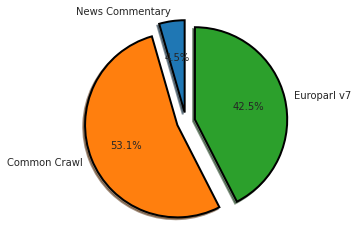

In [ ]:
#Visualization of merged dataset
len_df_nc =  len(df_nc)
len_df_cc =  len(df_cc)
len_df_ep =  len(df_ep)
# Create a Pandas DataFrame with the source and record counts
data_count = {
    'DataSource':["News Commentary","Common Crawl","Europarl v7"],
    'Counts' :[len_df_nc ,len_df_cc ,len_df_ep  ]
              }
df_cnt = pd.DataFrame(data_count)
#print(df_cnt)
labels = df_cnt.DataSource
valcounts =  df_cnt.Counts
explode = (0.1, 0.1, 0.1) 
print ("Percentage of data from source")
print ("-----" * 10)
plt.pie(valcounts, explode = explode,
        labels = labels, autopct = '%1.1f%%',
        shadow = True, startangle = 90,
        wedgeprops= {"edgecolor":"black",
                     'linewidth': 2,
                     'antialiased': True})  
plt.axis('equal')  
plt.show()
df_cnt.head()
df_cnt.style.hide_index()

### Primary Cleaning in below sequence


1.   Text Normalization - Converting sentences into lowercase
2.   Removing all URLs
3.   Removing all email address
4.   Removing contractions only for English dataset (Eg: wouldn't -> would not)
5.   Adding spaces before and after all punctuations
6.   Removing invalid characters for English language
7.   Removing invalid characters for German language
8.   Removing leading and trailing white space and return the cleaned text  




In [ ]:
#Declaring a function for data cleaning
def data_cleaning(text,lang_indicator):
  #Declaring necessary regular expressions
  url_regex = r'https?://\S+'
  email_regex = r'[\w.-]+@[\w.-]+\.[\w]+'
  spaces_around_punct_find = r'([^\s\w])'
  spaces_around_punct_replace = r' \1 '
  english_invalid_regex = r'[^a-zA-Z\s]+'
  german_invalid_regex = r'[^a-zA-ZäöüÄÖÜß\s]+'
  #Text Cleaning  
  text = text.lower() #Text Normalization - convert sentences into lowercase
  text = re.sub(url_regex,"",text) #Removing all URLs
  text = re.sub(email_regex,"", text) #Removing all email address
  if lang_indicator == 'en': 
    text = contractions.fix(text) #Removing contractions only for English dataset (Eg: wouldn't -> would not)
  text = re.sub(spaces_around_punct_find, spaces_around_punct_replace, text) #Adding spaces before and after all punctuations
  if lang_indicator == 'en':
    text = re.sub(english_invalid_regex,"",text) #Removing invalid characters for English language
  elif lang_indicator == 'de':
    text = re.sub(german_invalid_regex,"",text) #Removing invalid characters for German language
  text = " ".join(text.split()) #Removing extra spaces
  return text.lstrip().rstrip() #Removing leading and trailing white space and return the cleaned text  

In [ ]:
%%time
#Setting language indicator to perform language spective cleaning activites
lang_indicator_english = 'en'
lang_indicator_german = 'de'
#Invoking datacleaning in both English and German sentences
df_corpus['English'] = df_corpus['English'].progress_apply(data_cleaning, lang_indicator=lang_indicator_english)
df_corpus['German'] = df_corpus['German'].progress_apply(data_cleaning, lang_indicator=lang_indicator_german)

  0%|          | 0/4520620 [00:00<?, ?it/s]

  0%|          | 0/4520620 [00:00<?, ?it/s]

CPU times: user 5min 14s, sys: 4.07 s, total: 5min 18s
Wall time: 5min 22s


### Invalid language detection and removal (Keeps only language detectable sentences and removes rest)
Using pycld2 package to perform language detection

In [ ]:
#cld2.detect returns multi dimensional array as output and position [2][0][1] refers to detected language
%%time
df_corpus['Predict_English']= df_corpus['English'].progress_apply(lambda x: cld2.detect(x)[2][0][1])
df_corpus['Predict_German']= df_corpus['German'].progress_apply(lambda x: cld2.detect(x)[2][0][1])

  0%|          | 0/4520620 [00:00<?, ?it/s]

  0%|          | 0/4520620 [00:00<?, ?it/s]

CPU times: user 1min 43s, sys: 1.48 s, total: 1min 44s
Wall time: 1min 48s


In [ ]:
eng_all_count = df_corpus["Predict_English"].value_counts()
ger_all_count = df_corpus["Predict_German"].value_counts()

print('Size of dataframe before cleaning invalid sentences:',len(df_corpus))
#total_cnt = df_corpus.shape[0]
count_eng_in_engdata = eng_all_count[0] 
count_ger_in_gerdata = ger_all_count[0] 
org_all_count = df_corpus.shape[0]  #before segregating english and german db , get the original record count
#Get the actual English and German sentence 
df_corpus = df_corpus[(df_corpus['Predict_English'] == 'en') & (df_corpus['Predict_German'] =='de')]
df_corpus = df_corpus.reset_index()
print('Size of dataframe after cleaning invalid sentences:',len(df_corpus))

Size of dataframe before cleaning invalid sentences: 4520620
Size of dataframe after cleaning invalid sentences: 4285532


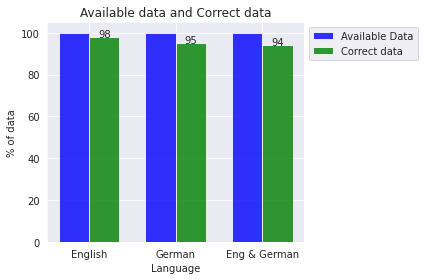

In [ ]:
#Visualization of invalid sentence removal
def annotate(x,y):
    for i in range(len(x)):
        #plt.text(i,y[i] ,y[i] ,  ha = 'center')
        plt.annotate(str(y[i]), xy=(x[i], y[i]), ha = 'center')
#get appropriate counts for english and german
total_cnt = org_all_count  
eng_count =  eng_all_count[0]
ger_count =  ger_all_count[0]
used_count =  df_corpus.shape[0]
# data to plot
n_groups = 3
avail_data = (100 ,100, 100)
used_data = ( int( (eng_count / total_cnt ) * 100 ),  int ((ger_count / total_cnt ) * 100 ) , int ((used_count / total_cnt ) * 100))
# create plot
fig, ax = plt.subplots()
index = np.arange(n_groups)
bar_width = 0.35
opacity = 0.8
avail_bar = plt.bar(index, avail_data, bar_width,
alpha=opacity,
color='b',
label='Available Data')
#plt.annotate(str(Y[index]), xy=(X[index], Y[index]))  
actual_bar = plt.bar(index + bar_width, used_data, bar_width,
alpha=opacity,
color='g',
label='Correct data')
annotate(index + bar_width , used_data)
plt.xlabel('Language')
plt.ylabel('% of data')
plt.title('Available data and Correct data')
plt.xticks(index + ( bar_width/2 ), ('English', 'German', 'Eng & German'))
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.tight_layout()
plt.show()

### Null records check

In [ ]:
print('Printing count of null values for each column in dataframe')
df_corpus.isna().sum()

Printing count of null values for each column in dataframe


index              0
German             0
English            0
Predict_English    0
Predict_German     0
dtype: int64

### Duplicate records check and action

In [ ]:
#Checking exact row duplicates
print('Number of exact row duplicate values in dataframe:', df_corpus.duplicated().sum())
#Checking duplicates for English and German list seperately
eng_dup_count = df_corpus['English'].duplicated().sum()
ger_dup_count = df_corpus['German'].duplicated().sum()
print('Number of duplicate entries in Englist list:',eng_dup_count)
print('Number of duplicate entries in German list:',ger_dup_count)
print('Number of entries in dataframe before duplicate removal:',len(df_corpus))
df_corpus.drop_duplicates(subset='English', inplace=True)
df_corpus.drop_duplicates(subset='German', inplace=True)
print('Number of entries in dataframe after duplicate removal:',len(df_corpus))

Number of exact row duplicate values in dataframe: 0
Number of duplicate entries in Englist list: 115303
Number of duplicate entries in German list: 67206
Number of entries in dataframe before duplicate removal: 4285532
Number of entries in dataframe after duplicate removal: 4159254


In [ ]:
#Data cleaning completed
print('Number of entries in dataframe before data cleaning is:',count_before_cleaning)
print('Number of entries in dataframe after data cleaning is:',len(df_corpus))

Number of entries in dataframe before data cleaning is: 4520620
Number of entries in dataframe after data cleaning is: 4159254


### Outlier check

In [ ]:
#Identifying word count for each sentence to identify potential outliers
df_corpus['English_wc'] = df_corpus['English'].progress_apply(lambda x: len(list(tokenize(x))))
df_corpus['German_wc'] = df_corpus['German'].progress_apply(lambda x: len(list(tokenize(x))))

  0%|          | 0/4159254 [00:00<?, ?it/s]

  0%|          | 0/4159254 [00:00<?, ?it/s]

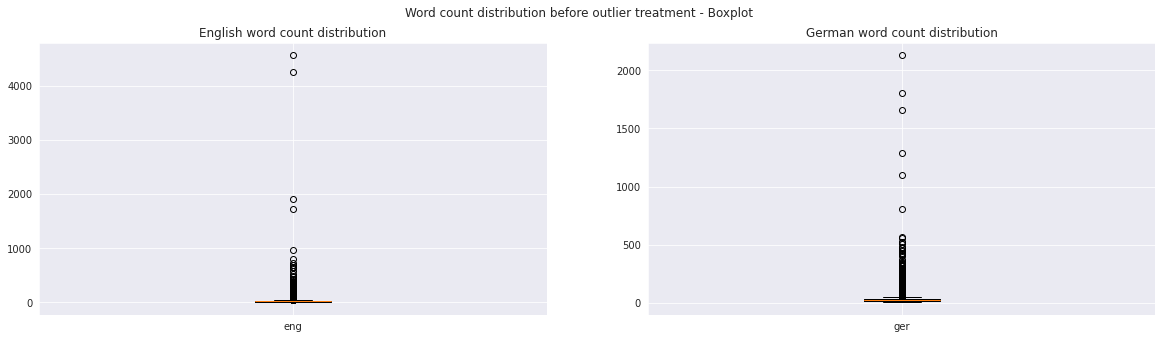

In [ ]:
#Visual Representation for displaying the word count before outlier treatment using Boxplot 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].boxplot(df_corpus['English_wc'], labels=['eng'])
axs[1].boxplot(df_corpus['German_wc'], labels=['ger'])
axs[0].set_title("English word count distribution")
axs[1].set_title("German word count distribution")
plt.suptitle("Word count distribution before outlier treatment - Boxplot")
plt.show() 

In [ ]:
#Defining a function to remove outliers
def find_and_remove_outliers(input_dataframe, columns_need_outlier_treatment):
    for i in columns_need_outlier_treatment:
        Q1 = input_dataframe[i].quantile(0.25)
        Q3 = input_dataframe[i].quantile(0.75)
        IQR = Q3 - Q1
        lower_limit = Q1 - 1.5*IQR
        upper_limit = Q3 + 1.5*IQR        
        output_dataframe = input_dataframe.loc[(input_dataframe[i] > lower_limit) & (input_dataframe[i] < upper_limit)]
    return output_dataframe

In [ ]:
#Removing outliers based on the wordcount
cols_for_outlier_treatment = ['English_wc','German_wc']
reduced_df = find_and_remove_outliers(df_corpus, cols_for_outlier_treatment)

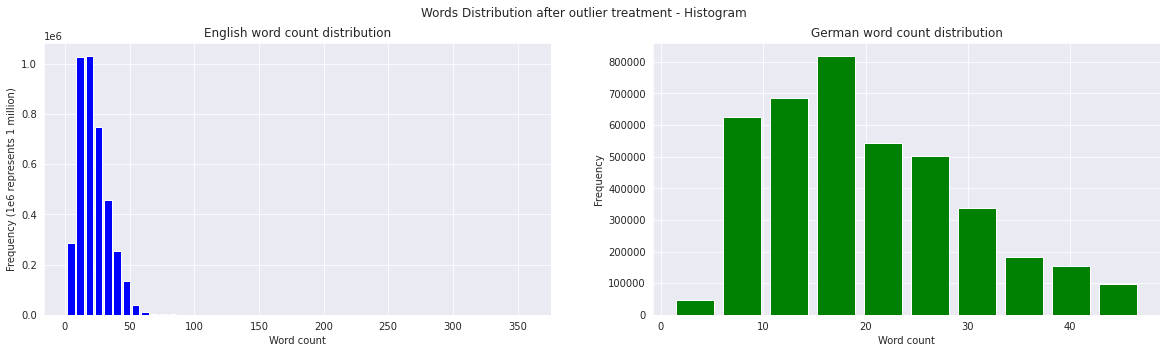

In [ ]:
#Visualisation for Words Distribution Using histogram  after Outlier Treatment 
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].hist(reduced_df['English_wc'], histtype='bar', rwidth=0.8, color='blue', label='eng', bins=50)
axs[1].hist(reduced_df['German_wc'], histtype='bar', rwidth=0.8, color='green', label='ger')
axs[0].set_title("English word count distribution")
axs[1].set_title("German word count distribution")
axs[0].set_xlabel('Word count')
axs[1].set_xlabel('Word count')
axs[0].set_ylabel('Frequency (1e6 represents 1 million)')
axs[1].set_ylabel('Frequency')
plt.ticklabel_format(style='plain')
plt.suptitle("Words Distribution after outlier treatment - Histogram")
plt.show()

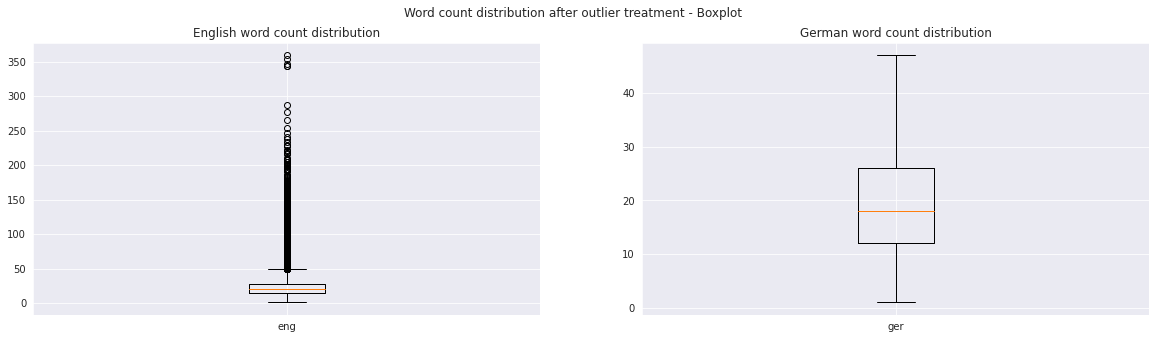

In [ ]:
#Visual Representation for Word Count distribution after Outlier treatment using boxplot
import matplotlib.pyplot as plt
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].boxplot(reduced_df['English_wc'], labels=['eng'])
axs[1].boxplot(reduced_df['German_wc'], labels=['ger'])
axs[0].set_title("English word count distribution")
axs[1].set_title("German word count distribution")
plt.suptitle("Word count distribution after outlier treatment - Boxplot")
plt.show()

In [ ]:
#Printing shape of corpus and dataframe without outliers
print('Shape of cleaned corpus:',df_corpus.shape)
print('Shape of dataframe (removed outliers):',reduced_df.shape)

Shape of cleaned corpus: (4159254, 7)
Shape of dataframe (removed outliers): (3995216, 7)


In [ ]:
# reduced_df.describe()
reduced_df[['English_wc','German_wc']].quantile([0.25, 0.5, 0.75])

English_wc  German_wc
0.25        14.0       12.0
0.50        20.0       18.0
0.75        28.0       26.0

In [ ]:
print('Shape of dataframe before word reduction :',reduced_df.shape)
word_reduction_limit = 10
print('Word reduction limit is:',word_reduction_limit)
df = reduced_df.loc[(reduced_df['English_wc'] < word_reduction_limit) & (reduced_df['German_wc'] < word_reduction_limit)]
print('Shape of dataframe after word reduction :',df.shape)

Shape of dataframe before word reduction : (3995216, 7)
Word reduction limit is: 10
Shape of dataframe after word reduction : (302958, 7)



### Train, Test and Validation Split

In [ ]:
def split_input_target(sample_size,model_type):
  random_state = 7
  df = loaded_df.sample(sample_size, random_state = 10, ignore_index = True)
  if (model_type == 'encoder_decoder'):
    df['German'] = df['German'].apply(lambda x: 'sos ' + x + ' eos')
    df['English'] = df['English'].apply(lambda x: 'sos '+ x + ' eos')
  X = df['English']
  Y = df['German']
  rand_state = 7
  test_ratio = 0.2
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y, random_state = rand_state, test_size=test_ratio)
  X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, random_state=rand_state, test_size=test_ratio)
  print ('Shape of X_train is :', X_train.shape)
  print ('Shape of X_test is :', X_test.shape)
  print ('Shape of X_validation is :', X_val.shape)
  print ('Shape of Y_train is :', Y_train.shape)
  print ('Shape of Y_test is :', Y_test.shape)
  print ('Shape of Y_validation is :', Y_val.shape)
  return X_train,X_test,Y_train,Y_test,X_val,Y_val
sample_size = 50000
X_train,X_test,Y_train,Y_test,X_val,Y_val = split_input_target(sample_size,'regular')

Shape of X_train is : (32000,)
Shape of X_test is : (10000,)
Shape of X_validation is : (8000,)
Shape of Y_train is : (32000,)
Shape of Y_test is : (10000,)
Shape of Y_validation is : (8000,)


### Tokenization, Sequencing and Padding

In [ ]:
#Defining a function to perform Tokenization, Sequencing and Padding
def tokenize_seq_pad(train, test, val, token_len, lang_indicator):         
  tokenizer= Tokenizer()
  tokenizer.fit_on_texts(train)
  word_index = tokenizer.word_index
  vocab_size = len(word_index)+1
  longest_word = max(word_index.keys(), key = len)
  maxlen_word  = len(longest_word)
  tokenized_train = tokenizer.texts_to_sequences(train)
  #maxlen_data = max([len(tokenized_string) for tokenized_string in tokenized_train])
  if token_len != None:
    maxlen_data = token_len
  else:
    maxlen_data = max([len(tokenized_string) for tokenized_string in tokenized_train])
  padded_train = pad_sequences(tokenized_train, maxlen=maxlen_data, padding='post')
  tokenized_test = tokenizer.texts_to_sequences(test)
  padded_test = pad_sequences(tokenized_test, maxlen=maxlen_data, padding='post')
  tokenized_val = tokenizer.texts_to_sequences(val)
  padded_val = pad_sequences(tokenized_val, maxlen=maxlen_data, padding='post')
  vocab_size = len(word_index) + 1
  longest_word = max(word_index.keys(), key = len)
  len_longest_word  = len(longest_word)
  if lang_indicator == 'en':
    print('-'*100)
    print('Printing Details for English language:')
  elif lang_indicator == 'de':
    print('-'*100)
    print('Printing Details for German language:')
  print('Below are the details after performing tokenization, sequencing and padding:')
  print('Max token length :',maxlen_data)
  print('Vocab Count :',vocab_size)
  print('Longest word :',longest_word)
  print('Length of longest word :',len_longest_word)
  print('Printing random sentence and corresponding padded tokens:')
  rand = np.random.randint(0,len(train))
  print('Below is the original sentence:')
  print(X_train.values[rand])
  print('Below is the padded tokens for the above sentence')
  print(padded_train[rand])
  print('-'*100)
  return (padded_train, padded_test, padded_val, maxlen_data, vocab_size, word_index, tokenizer,tokenized_train)
X_train_proc,X_test_proc,X_val_proc,eng_MaxLength,eng_VocabSize,eng_WordIndex,eng_Tokenizer,eng_TokenizedStrings = tokenize_seq_pad(X_train, X_test, X_val, word_reduction_limit, 'en')
Y_train_proc,Y_test_proc,Y_val_proc,ger_MaxLength,ger_VocabSize,ger_WordIndex,ger_Tokenizer,ger_TokenizedStrings = tokenize_seq_pad(Y_train, Y_test, Y_val, word_reduction_limit, 'de')

----------------------------------------------------------------------------------------------------
Printing Details for English language:
Below are the details after performing tokenization, sequencing and padding:
Max token length : 10
Vocab Count : 20605
Longest word : annunciimmobiliarimultilingue
Length of longest word : 29
Printing random sentence and corresponding padded tokens:
Below is the original sentence:
in my opinion the procedure needs to be revised
Below is the padded tokens for the above sentence
[   6   54  852    1  609  241    3   15 2649    0]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Printing Details for German language:
Below are the details after performing tokenization, sequencing and padding:
Max token length : 10
Vocab Count : 32402
Longest word : telekommunikationsendeinrichtungen
Length of longest w

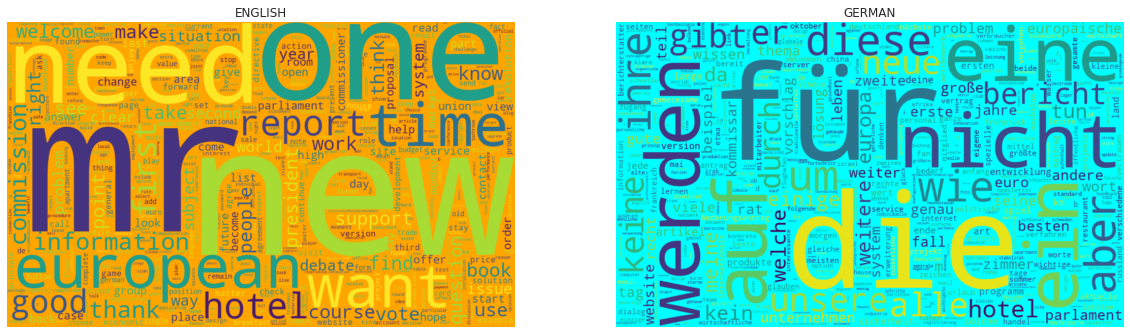

In [ ]:
#Displying WordCloud for English and German values
plt.figure(figsize = (20,20))
plt.subplot(1,2,1)
wc = WordCloud(max_words = 500 , width = 1000 , height = 600, background_color="orange").generate(" ".join(eng_WordIndex.keys()))
plt.imshow(wc ,interpolation = 'bilinear');
plt.grid(False)
plt.axis('off')
plt.title('ENGLISH')
plt.subplot(1,2,2)
wc = WordCloud(max_words = 500 , width = 1000 , height = 600, background_color="cyan").generate(" ".join(ger_WordIndex.keys()))
plt.imshow(wc ,interpolation = 'bilinear');
plt.title('GERMAN')
plt.grid(False)
plt.axis('off')
plt.show()

In [ ]:
def top10_words(word_index):
  result = []
  count = 0
  for k in word_index:
    if k != 'eos' and k!='sos':
      result.append(k)
      count +=1
    if count == 10:
      break
  return result
eng_freq = top10_words(eng_WordIndex.keys())
ger_freq = top10_words(ger_WordIndex.keys())
topN = 10
df_freq = pd.DataFrame(list(zip(eng_freq, ger_freq)), columns=['ENGLISH', 'GERMAN'])
df_freq 

ENGLISH GERMAN
0     the    die
1      is    der
2      to    ist
3      of    das
4       a    sie
5      in    und
6    this    wir
7     and     in
8      we    ich
9     for    für

In [ ]:
#Creating a dataframe to record metrics of trained models
df_summary = pd.DataFrame(columns = ['Model','Test Accuracy', 'Validation Accuracy', 'Train Accuracy','SacreBleu','METEOR - Average','METEOR - Max'])

In [ ]:
#######Functions for Model Building#######

#Reshaping the vaues to get three dimensional shapes
X_tr_reshaped = X_train_proc.reshape(X_train_proc.shape[0],X_train_proc.shape[1],1)
X_te_reshaped = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1],1)
X_va_reshaped = X_val_proc.reshape(X_val_proc.shape[0], X_val_proc.shape[1],1)
Y_tr_reshaped = Y_train_proc.reshape(Y_train_proc.shape[0],Y_train_proc.shape[1],1)
Y_te_reshaped = Y_test_proc.reshape(Y_test_proc.shape[0], Y_test_proc.shape[1],1)
Y_va_reshaped = Y_val_proc.reshape(Y_val_proc.shape[0], Y_val_proc.shape[1],1)


#Define function to define earlystopping, Modelcheckpoint and fit instructions
def train_and_fit_model(model, epochs, batch_size, train_X, train_y_reshaped, val_X, val_y_reshaped, filename):
  earlystopping = callbacks.EarlyStopping(monitor ="val_loss", mode ="min", patience = 5, restore_best_weights = True)
  modelcheck = ModelCheckpoint(filename, monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)
  history = model.fit(train_X, train_y_reshaped, batch_size=batch_size, epochs=epochs, validation_data=(val_X, val_y_reshaped), verbose=2,  callbacks = [earlystopping, modelcheck], shuffle=True)
  saved_model = load_model(filename)
  return history

#######Functions for Performance Calculation#######

#Defining a function to calculate accuracy
def model_evaluate(model, feature, label):
  accuracy = model.evaluate(feature, label, verbose=0)  
  return accuracy[1]

#Defining a function to calculate METEOR score for accuracy of predicted sentences
def meteor_calc(actual, predicted):
  result = []
  for i in range(len(actual)):
    score = round(meteor_score.single_meteor_score(word_tokenize(actual[i]),word_tokenize(predicted[i]),gamma=0),4)       
    result.append(score)
  return result
  
#Defining a function to calculate sacreblue and wer accuracy
def corpus_accuracy(predicted_df):
  bleu = BLEU()
  #rouge = Rouge()
  actual = predicted_df['actual'].tolist()
  predicted = predicted_df['predicted'].tolist()
  sacrebleu_score = bleu.corpus_score(predicted, [actual])
  sacrebleu_score = float(re.search(r"(BLEU = ([^ ]+))", str(sacrebleu_score)).group(2))  
  #wer_score = wer(predicted, actual)
  #rouge_score = rouge.get_scores(predicted, actual, avg=True)
  #print(rouge_score)
  return sacrebleu_score#, rouge_score

#Plotting loss and accuracy details from training and validation data
def plot_results(history_data):
  plt.figure(figsize=(10, 5))
  plt.subplot(1,2,1)
  epochs = len(history_data.epoch)
  plt.plot(np.arange(0, epochs), history_data.history["loss"], label="Training Loss")
  plt.plot(np.arange(0, epochs), history_data.history["val_loss"], label="Validation Loss")
  plt.title('Training and Validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.subplot(1,2,2)
  plt.plot(np.arange(0, epochs), history_data.history["accuracy"], label="Training Accuracy")
  plt.plot(np.arange(0, epochs), history_data.history["val_accuracy"], label="Validation Accuracy")
  plt.title('Training and Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()
  plt.show()

#######Functions for Prediction#######


#Defining a function to decode predicted values to words
def decode_numbers_to_words(n, tokenizer):
      for word, index in tokenizer.word_index.items():
          if index == n:
              return word
      return None
#Defining a function to fetch and store results for predicted values for comparison
def fetch_results_from_prediction(results,tokenizer):
  predicted_text = []
  for i in results:
        temp = []
        for j in range(len(i)):
              t = decode_numbers_to_words(i[j], tokenizer)
              if j > 0:
                  if (t == decode_numbers_to_words(i[j-1], tokenizer)) or (t == None):
                      temp.append('')
                  else:
                      temp.append(t)
              else:
                    if(t == None):
                            temp.append('')
                    else:
                            temp.append(t) 
        predicted_text.append(' '.join(temp))
  return predicted_text

drive_location_to_save_trained_models = '/content/drive/MyDrive/Learning/'
file_extension_name = '.h5'
def print_and_store_accuracy(model_name, Input_train, Input_val, Input_test, Target_train, Target_val, Target_test):
  loaded_model = load_model(model_name)
  model_name_with_location = drive_location_to_save_trained_models + model_name + file_extension_name
  loaded_model.save(model_name_with_location)
  test_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_test, Target_test))
  val_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_val, Target_val))
  train_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_train, Target_train))
  print('Printing accuracy details for',model_name)
  print('Test Accuracy:',test_acc)
  print('Validation Accuracy:',val_acc)
  print('Train Accuracy:',train_acc)
  df_summary.loc[len(df_summary.index)] = [model_name,test_acc,val_acc,train_acc,'','','']
  return loaded_model

def load_and_display_accuracy(model_location, Input_train, Input_val, Input_test, Target_train, Target_val, Target_test):
  loaded_model = load_model(model_location)
  # model_name_with_location = drive_location_to_save_trained_models + model_name + file_extension_name
  # loaded_model.save(model_name_with_location)
  model_name = model_location.replace('/content/drive/MyDrive/Learning/','')
  model_name = model_name.replace('.h5','')
  test_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_test, Target_test))
  val_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_val, Target_val))
  train_acc = '{:.2%}'.format(model_evaluate(loaded_model, Input_train, Target_train))
  print('Printing accuracy details for',model_name)
  print('Test Accuracy:',test_acc)
  print('Validation Accuracy:',val_acc)
  print('Train Accuracy:',train_acc)
  df_summary.loc[len(df_summary.index)] = [model_name,test_acc,val_acc,train_acc,'','','']
  return loaded_model


def predict_and_print_top_20(loaded_model, input_test_for_model,input_test_original, target_test_original, tokenizer_to_decode):
  #@tf.function(experimental_relax_shapes=True)
  predict_data = loaded_model.predict(input_test_for_model[0:20], verbose=0)
  predict_classes = np.argmax(predict_data, axis=-1)
  #Creating a dataframe to capture and compare input, acutal and predicted output
  prediction_results = fetch_results_from_prediction(predict_classes,tokenizer_to_decode)
  meteorscore = meteor_calc(target_test_original[0:20].values,prediction_results)
  df_predict = pd.DataFrame({'input':input_test_original[0:20].values,
                             'actual' : target_test_original[0:20].values, 'predicted': prediction_results,
                             'METEOR' : meteorscore})
  sacreblue_acc = corpus_accuracy(df_predict)
  df_summary.loc[(len(df_summary.index)-1), 'SacreBleu'] = round(sacreblue_acc,2)
  # df_summary.loc[(len(df_summary.index)-1), 'WER'] = round(wer_acc,2)
  df_summary.loc[(len(df_summary.index)-1), 'METEOR - Average'] = round(df_predict['METEOR'].mean(),2)
  df_summary.loc[(len(df_summary.index)-1), 'METEOR - Max'] = round(df_predict['METEOR'].max(),2)
  return df_predict,df_summary


def highlight_pred(s):
  if s.name == 'METEOR':
      is_max = s == s.max()
  else:
      is_max = [False for _ in range(s.shape[0])]
  return ['background: lightgreen' if cell else '' for cell in is_max]

def predict_results(count,loaded_model,input_test_for_model,input_test_original,target_test_original,tokenizer_to_decode):
  fixed_state = RandomState(77)
  random_index = []
  predict_data = []
  target_test_original_array = []
  input_test_original_array = []
  for i in fixed_state.randint(0, len(input_test_original), size=count):
    data = loaded_model.predict(input_test_for_model[i], verbose =0)
    predict_data.append(data)
    random_index.append(i)
    target_test_original_array.append(target_test_original.values[i])
    input_test_original_array.append(input_test_original.values[i])
  predict_classes = np.argmax(predict_data, axis=-1)
  #print(predict_classes)
  prediction_results = fetch_results_from_prediction(predict_classes,tokenizer_to_decode)
  meteorscore = meteor_calc(target_test_original_array,prediction_results)
  df_predict = pd.DataFrame({'random_index':random_index,'input':input_test_original_array,
                              'actual' : target_test_original_array, 'predicted': prediction_results,
                              'METEOR' : meteorscore
                              })
  df_predict.set_index('random_index', inplace=True)
  sacreblue_acc = corpus_accuracy(df_predict)
  df_summary.loc[(len(df_summary.index)-1), 'SacreBleu'] = round(sacreblue_acc,2)
  #df_summary.loc[(len(df_summary.index)-1), 'WER'] = round(wer_acc,2)
  df_summary.loc[(len(df_summary.index)-1), 'METEOR - Average'] = round(df_predict['METEOR'].mean(),2)
  df_summary.loc[(len(df_summary.index)-1), 'METEOR - Max'] = round(df_predict['METEOR'].max(),2)
  # df_rouge = pd.DataFrame(rouge_score)
  # df_rouge = df_rouge.apply(lambda x: round(x*100,2))
  return df_predict,df_summary#,df_rouge
#Defining function for highlighting max values in df_summry
def highlight_summary(s):
    if s.name == 'Model':
        is_max = [False for _ in range(s.shape[0])]
    else:
        is_max = s == s.max()
    return ['background: lightgreen' if cell else '' for cell in is_max]

### Simple RNN

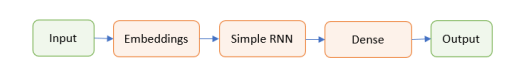

In [ ]:
simple_rnn_diagram = Image.open(r"/content/drive/MyDrive/Learning/simple_rnn_diagram.png")
simple_rnn_diagram

#### Model Building and Training (Simple RNN Model - English to German)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 256)           5274880   
                                                                 
 simple_rnn (SimpleRNN)      (None, 10, 512)           393728    
                                                                 
 dense (Dense)               (None, 10, 32402)         16622226  
                                                                 
Total params: 22,290,834
Trainable params: 22,290,834
Non-trainable params: 0
_________________________________________________________________


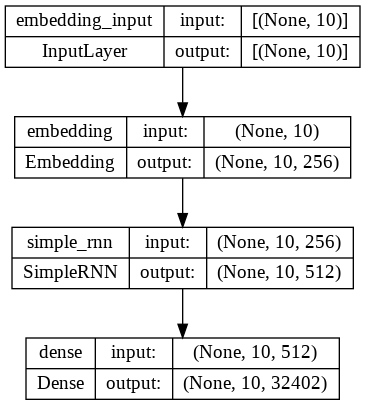

In [ ]:
simple_rnn_model = Sequential()
simple_rnn_model.add(Embedding(eng_VocabSize, 256, input_length=eng_MaxLength, mask_zero=True))
simple_rnn_model.add(SimpleRNN(512, return_sequences=True))
simple_rnn_model.add(Dense(ger_VocabSize, activation='softmax'))
simple_rnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
simple_rnn_model.summary()
simple_rnn_pic = "/content/drive/MyDrive/Learning/simple_rnn.png"
plot_model(simple_rnn_model, to_file= simple_rnn_pic, show_shapes=True, show_layer_names=True)

In [ ]:
simple_rnn_model_name = 'simple_RNN_en_de'
epoch_val = 30
batch_size = 256
simple_rnn_history = train_and_fit_model(simple_rnn_model, epoch_val, batch_size, X_train_proc, Y_tr_reshaped, X_val_proc, Y_va_reshaped, simple_rnn_model_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.13516, saving model to simple_RNN_en_de
125/125 - 23s - loss: 5.9261 - accuracy: 0.0905 - val_loss: 4.6989 - val_accuracy: 0.1352 - 23s/epoch - 186ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.13516 to 0.16118, saving model to simple_RNN_en_de
125/125 - 20s - loss: 5.2228 - accuracy: 0.1086 - val_loss: 4.4388 - val_accuracy: 0.1612 - 20s/epoch - 160ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.16118 to 0.18719, saving model to simple_RNN_en_de
125/125 - 20s - loss: 4.9566 - accuracy: 0.1363 - val_loss: 4.2705 - val_accuracy: 0.1872 - 20s/epoch - 158ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.18719 to 0.20868, saving model to simple_RNN_en_de
125/125 - 20s - loss: 4.6903 - accuracy: 0.1695 - val_loss: 4.1567 - val_accuracy: 0.2087 - 20s/epoch - 158ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.20868 to 0.22652, saving model to simple_RNN_en_de
125/125 - 20s - loss: 4.4223 - accurac

#### Performance Results (Simple RNN Model - English to German)

Printing accuracy details for simple_RNN_en_de
Test Accuracy: 24.72%
Validation Accuracy: 24.96%
Train Accuracy: 34.70%


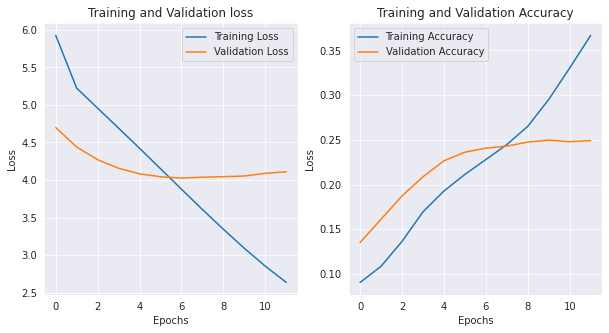

In [ ]:
load_trained_simple_rnn = print_and_store_accuracy(simple_rnn_model_name,X_train_proc,X_val_proc,X_test_proc,Y_tr_reshaped,Y_va_reshaped,Y_te_reshaped)
plot_results(simple_rnn_history)

In [ ]:
location_simple_RNN_en_de = '/content/drive/MyDrive/Learning/simple_RNN_en_de.h5'
load_trained_simple_rnn = load_and_display_accuracy(location_simple_RNN_en_de,X_train_proc,X_val_proc,X_test_proc,Y_tr_reshaped,Y_va_reshaped,Y_te_reshaped)

Printing accuracy details for simple_RNN_en_de
Test Accuracy: 24.72%
Validation Accuracy: 24.96%
Train Accuracy: 34.70%


In [ ]:
simple_rnn_en_de_predicted_df,df_summary = predict_and_print_top_20(load_trained_simple_rnn,X_te_reshaped, X_test, Y_test, ger_Tokenizer)
simple_rnn_en_de_predicted_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0  simple_RNN_en_de        24.72%              24.96%         34.70%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68

###Simple RNN - Observation


1.   **Simple Recurrent Nueral Network** model couldn't predict most of the models (Test accuracy < 25%)
2.   Issue could be with model's memory handling capacity. **Long short-term memory (LSTM)** can be explored further for better handling. 



### Simple LSTM

#### Simple LSTM (English to German)

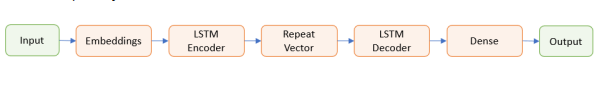

In [ ]:
Simple_LSTM_diagram = Image.open(r"/content/drive/MyDrive/Learning/Simple_LSTM_diagram.png")
Simple_LSTM_diagram

#### Model Building and Training (Simple LSTM Model - English to German)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 1024)          21099520  
                                                                 
 lstm (LSTM)                 (None, 512)               3147776   
                                                                 
 repeat_vector (RepeatVector  (None, 10, 512)          0         
 )                                                               
                                                                 
 lstm_1 (LSTM)               (None, 10, 512)           2099200   
                                                                 
 dense_1 (Dense)             (None, 10, 32402)         16622226  
                                                                 
Total params: 42,968,722
Trainable params: 42,968,722
Non-trainable params: 0
__________________________________________

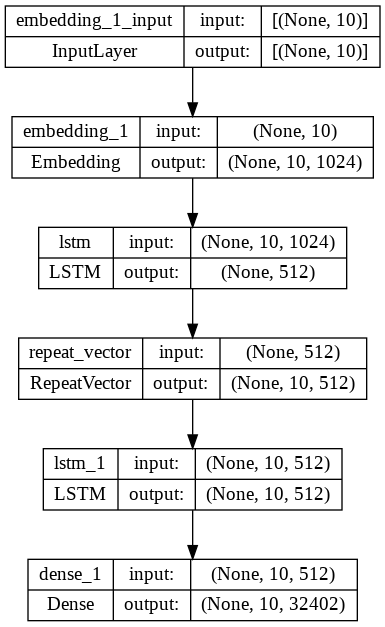

In [ ]:
simple_lstm_model = Sequential()
simple_lstm_model.add(Embedding(eng_VocabSize, 1024, input_length=eng_MaxLength, mask_zero=True))
simple_lstm_model.add(LSTM(512))
simple_lstm_model.add(RepeatVector(ger_MaxLength))
simple_lstm_model.add(LSTM(512, return_sequences=True))
simple_lstm_model.add(Dense(ger_VocabSize, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.001)
simple_lstm_model.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
simple_lstm_model.summary()
#Displaying simple LSTM model (en-de) used for training
simple_lstm_en_de_pic = "/content/drive/MyDrive/Learning/simple_lstm_en_de.png"
plot_model(simple_lstm_model, to_file= simple_lstm_en_de_pic, show_shapes=True, show_layer_names=True)

In [ ]:
#Training simple LSTM model (en-de)
simple_lstm_model_name = 'simple_LSTM_en_de'
epoch_val = 30
batch_size = 256
simple_lstm_history = train_and_fit_model(simple_lstm_model, epoch_val, batch_size, X_train_proc, Y_tr_reshaped, X_val_proc, Y_va_reshaped, simple_lstm_model_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.38226, saving model to simple_LSTM_en_de


125/125 - 42s - loss: 6.0527 - accuracy: 0.3065 - val_loss: 4.7684 - val_accuracy: 0.3823 - 42s/epoch - 340ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.38226 to 0.38850, saving model to simple_LSTM_en_de


125/125 - 35s - loss: 5.4914 - accuracy: 0.3234 - val_loss: 4.6297 - val_accuracy: 0.3885 - 35s/epoch - 277ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.38850 to 0.39693, saving model to simple_LSTM_en_de


125/125 - 36s - loss: 5.2726 - accuracy: 0.3346 - val_loss: 4.5563 - val_accuracy: 0.3969 - 36s/epoch - 285ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.39693 to 0.41020, saving model to simple_LSTM_en_de


125/125 - 35s - loss: 5.0881 - accuracy: 0.3496 - val_loss: 4.4211 - val_accuracy: 0.4102 - 35s/epoch - 282ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.41020
125/125 - 21s - loss: 4.9162 - accuracy: 0.3605 - val_loss: 4.4146 - val_accuracy: 0.4075 - 21s/epoch - 166ms/step
Epoch 6/30

Epoch 6: val_accuracy improved from 0.41020 to 0.42421, saving model to simple_LSTM_en_de


125/125 - 35s - loss: 4.7426 - accuracy: 0.3718 - val_loss: 4.2688 - val_accuracy: 0.4242 - 35s/epoch - 279ms/step
Epoch 7/30

Epoch 7: val_accuracy did not improve from 0.42421
125/125 - 21s - loss: 4.5754 - accuracy: 0.3807 - val_loss: 4.2511 - val_accuracy: 0.4203 - 21s/epoch - 167ms/step
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.42421
125/125 - 21s - loss: 4.4072 - accuracy: 0.3905 - val_loss: 4.2688 - val_accuracy: 0.4166 - 21s/epoch - 167ms/step
Epoch 9/30

Epoch 9: val_accuracy improved from 0.42421 to 0.43178, saving model to simple_LSTM_en_de


125/125 - 36s - loss: 4.2474 - accuracy: 0.3987 - val_loss: 4.1635 - val_accuracy: 0.4318 - 36s/epoch - 290ms/step
Epoch 10/30

Epoch 10: val_accuracy did not improve from 0.43178
125/125 - 21s - loss: 4.0907 - accuracy: 0.4074 - val_loss: 4.1936 - val_accuracy: 0.4270 - 21s/epoch - 167ms/step
Epoch 11/30

Epoch 11: val_accuracy did not improve from 0.43178
125/125 - 21s - loss: 3.9301 - accuracy: 0.4162 - val_loss: 4.1713 - val_accuracy: 0.4316 - 21s/epoch - 168ms/step
Epoch 12/30

Epoch 12: val_accuracy did not improve from 0.43178
125/125 - 21s - loss: 3.7789 - accuracy: 0.4243 - val_loss: 4.1876 - val_accuracy: 0.4313 - 21s/epoch - 169ms/step
Epoch 13/30

Epoch 13: val_accuracy did not improve from 0.43178
125/125 - 21s - loss: 3.6295 - accuracy: 0.4332 - val_loss: 4.2027 - val_accuracy: 0.4299 - 21s/epoch - 170ms/step
Epoch 14/30

Epoch 14: val_accuracy improved from 0.43178 to 0.43235, saving model to simple_LSTM_en_de


125/125 - 35s - loss: 3.4839 - accuracy: 0.4426 - val_loss: 4.2427 - val_accuracy: 0.4324 - 35s/epoch - 283ms/step


#### Performance Results (Simple LSTM Model - English to German)

Printing accuracy details for simple_LSTM_en_de
Test Accuracy: 43.25%
Validation Accuracy: 43.18%
Train Accuracy: 40.72%


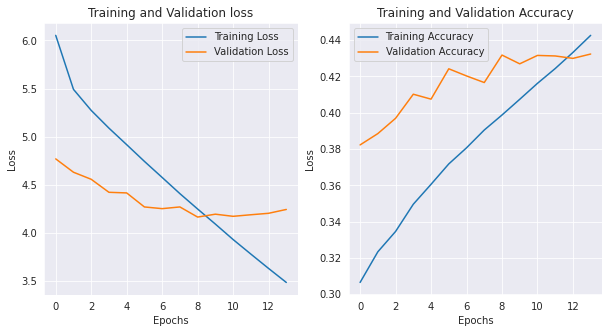

In [ ]:
load_trained_simple_lstm = print_and_store_accuracy(simple_lstm_model_name,X_train_proc,X_val_proc,X_test_proc,Y_tr_reshaped,Y_va_reshaped,Y_te_reshaped)
plot_results(simple_lstm_history)

In [ ]:
location_simple_LSTM_en_de = '/content/drive/MyDrive/Learning/simple_LSTM_en_de.h5'
load_trained_simple_lstm = load_and_display_accuracy(location_simple_LSTM_en_de,X_train_proc,X_val_proc,X_test_proc,Y_tr_reshaped,Y_va_reshaped,Y_te_reshaped)

Printing accuracy details for simple_LSTM_en_de
Test Accuracy: 43.25%
Validation Accuracy: 43.18%
Train Accuracy: 40.72%


#### Prediction (Simple LSTM Model - English to German)

In [ ]:
simple_lstm_en_de_predicted_df,df_summary = predict_and_print_top_20(load_trained_simple_lstm,X_te_reshaped, X_test, Y_test, ger_Tokenizer)
simple_lstm_en_de_predicted_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0   simple_RNN_en_de        24.72%              24.96%         34.70%   
1  simple_LSTM_en_de        43.25%              43.18%         40.72%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52

### Simple LSTM (English to German) - Observation


1.   Simple LSTM model was able to predict few words correct and comparitively better than Simple RNN (~20% increase in test accuracy).
2.   We can explore embeddings and bi-directional LSTM for better predictions.



#### Simple LSTM (German to English)

#### Model Building and Training (Simple LSTM Model - German to English)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 1024)          33179648  
                                                                 
 lstm_2 (LSTM)               (None, 512)               3147776   
                                                                 
 repeat_vector_1 (RepeatVect  (None, 10, 512)          0         
 or)                                                             
                                                                 
 lstm_3 (LSTM)               (None, 10, 512)           2099200   
                                                                 
 dense_2 (Dense)             (None, 10, 20605)         10570365  
                                                                 
Total params: 48,996,989
Trainable params: 48,996,989
Non-trainable params: 0
__________________________________________

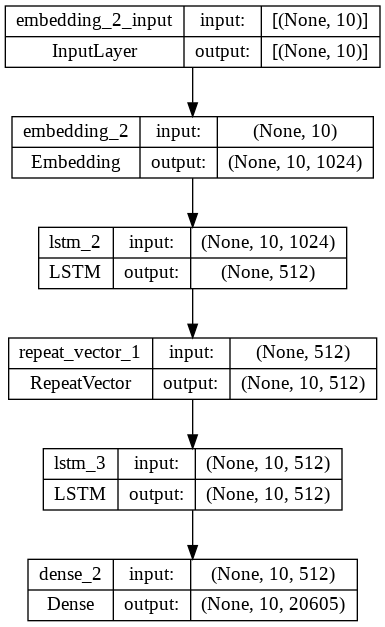

In [ ]:
simple_lstm_model_de_en = Sequential()
simple_lstm_model_de_en.add(Embedding(ger_VocabSize, 1024, input_length=ger_MaxLength, mask_zero=True))
simple_lstm_model_de_en.add(LSTM(512))
simple_lstm_model_de_en.add(RepeatVector(eng_MaxLength))
simple_lstm_model_de_en.add(LSTM(512, return_sequences=True))
simple_lstm_model_de_en.add(Dense(eng_VocabSize, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.001)
simple_lstm_model_de_en.compile(optimizer=rms, loss='sparse_categorical_crossentropy',metrics=['accuracy'])
print(simple_lstm_model_de_en.summary())
#Displaying simple LSTM model (de-en) used for training
simple_lstm_de_en_pic = "/content/drive/MyDrive/Learning/simple_lstm_de_en.png"
plot_model(simple_lstm_model_de_en, to_file= simple_lstm_de_en_pic, show_shapes=True, show_layer_names=True)

In [ ]:
#Training simple LSTM model (de-en)
simple_lstm_model_name_de_en = 'simple_LSTM_de_en'
epoch_val = 30
batch_size = 256
simple_lstm_history_de_en = train_and_fit_model(simple_lstm_model_de_en, epoch_val, batch_size, Y_train_proc, X_tr_reshaped, Y_val_proc, X_va_reshaped, simple_lstm_model_name_de_en)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.34159, saving model to simple_LSTM_de_en


125/125 - 31s - loss: 5.3322 - accuracy: 0.3076 - val_loss: 4.8235 - val_accuracy: 0.3416 - 31s/epoch - 244ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.34159 to 0.35831, saving model to simple_LSTM_de_en


125/125 - 29s - loss: 5.1046 - accuracy: 0.3184 - val_loss: 4.7164 - val_accuracy: 0.3583 - 29s/epoch - 236ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.35831 to 0.36658, saving model to simple_LSTM_de_en


125/125 - 29s - loss: 4.9146 - accuracy: 0.3334 - val_loss: 4.6093 - val_accuracy: 0.3666 - 29s/epoch - 229ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.36658 to 0.37286, saving model to simple_LSTM_de_en


125/125 - 30s - loss: 4.7319 - accuracy: 0.3480 - val_loss: 4.5337 - val_accuracy: 0.3729 - 30s/epoch - 241ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.37286 to 0.38348, saving model to simple_LSTM_de_en


125/125 - 29s - loss: 4.5526 - accuracy: 0.3637 - val_loss: 4.4624 - val_accuracy: 0.3835 - 29s/epoch - 229ms/step
Epoch 6/30

Epoch 6: val_accuracy improved from 0.38348 to 0.38633, saving model to simple_LSTM_de_en


125/125 - 30s - loss: 4.3711 - accuracy: 0.3795 - val_loss: 4.4135 - val_accuracy: 0.3863 - 30s/epoch - 242ms/step
Epoch 7/30

Epoch 7: val_accuracy improved from 0.38633 to 0.39519, saving model to simple_LSTM_de_en


125/125 - 29s - loss: 4.1984 - accuracy: 0.3927 - val_loss: 4.4008 - val_accuracy: 0.3952 - 29s/epoch - 229ms/step
Epoch 8/30

Epoch 8: val_accuracy improved from 0.39519 to 0.39609, saving model to simple_LSTM_de_en


125/125 - 30s - loss: 4.0299 - accuracy: 0.4057 - val_loss: 4.3936 - val_accuracy: 0.3961 - 30s/epoch - 241ms/step
Epoch 9/30

Epoch 9: val_accuracy did not improve from 0.39609
125/125 - 14s - loss: 3.8639 - accuracy: 0.4168 - val_loss: 4.4007 - val_accuracy: 0.3905 - 14s/epoch - 116ms/step
Epoch 10/30

Epoch 10: val_accuracy did not improve from 0.39609
125/125 - 14s - loss: 3.7065 - accuracy: 0.4288 - val_loss: 4.4208 - val_accuracy: 0.3957 - 14s/epoch - 115ms/step
Epoch 11/30

Epoch 11: val_accuracy improved from 0.39609 to 0.40074, saving model to simple_LSTM_de_en


125/125 - 29s - loss: 3.5480 - accuracy: 0.4403 - val_loss: 4.4659 - val_accuracy: 0.4007 - 29s/epoch - 229ms/step
Epoch 12/30

Epoch 12: val_accuracy did not improve from 0.40074
125/125 - 15s - loss: 3.3917 - accuracy: 0.4515 - val_loss: 4.4829 - val_accuracy: 0.3927 - 15s/epoch - 116ms/step
Epoch 13/30

Epoch 13: val_accuracy did not improve from 0.40074
125/125 - 15s - loss: 3.2443 - accuracy: 0.4637 - val_loss: 4.5535 - val_accuracy: 0.3992 - 15s/epoch - 117ms/step


#### Performance Results (Simple LSTM Model - German to English)

Printing accuracy details for simple_LSTM_de_en
Test Accuracy: 40.12%
Validation Accuracy: 40.07%
Train Accuracy: 45.58%


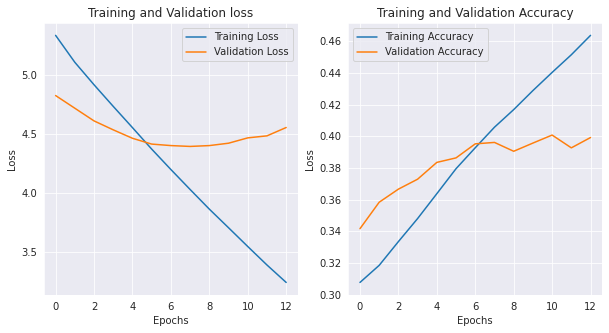

In [ ]:
load_trained_simple_lstm_de_en = print_and_store_accuracy(simple_lstm_model_name_de_en,Y_train_proc,Y_val_proc,Y_test_proc,X_tr_reshaped,X_va_reshaped,X_te_reshaped)
plot_results(simple_lstm_history_de_en)

In [ ]:
location_simple_LSTM_de_en = '/content/drive/MyDrive/Learning/simple_LSTM_de_en.h5'
load_trained_simple_lstm_de_en = load_and_display_accuracy(location_simple_LSTM_de_en,Y_train_proc,Y_val_proc,Y_test_proc,X_tr_reshaped,X_va_reshaped,X_te_reshaped)

Printing accuracy details for simple_LSTM_de_en
Test Accuracy: 40.12%
Validation Accuracy: 40.07%
Train Accuracy: 45.58%


#### Prediction (Simple LSTM Model - German to English)

In [ ]:
simple_lstm_de_en_predicted_df,df_summary = predict_and_print_top_20(load_trained_simple_lstm_de_en,Y_te_reshaped, Y_test, X_test, eng_Tokenizer)
simple_lstm_de_en_predicted_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0   simple_RNN_en_de        24.72%              24.96%         34.70%   
1  simple_LSTM_en_de        43.25%              43.18%         40.72%   
2  simple_LSTM_de_en        40.12%              40.07%         45.58%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69

### Simple LSTM (German to English) - Observation


1.   Simple LSTM (German to English) model was able to predict number of words correctly.
2.   Accuracy is marginally lesser while comparing to similar model with input as English and output as German.
3.   We can explore embeddings and bi-directional LSTM for better predictions.




## Results and Model comparison

In [ ]:
#Displaying comparison of models with their accuracy values of Test, Validation and Train data
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0   simple_RNN_en_de        24.72%              24.96%         34.70%   
1  simple_LSTM_en_de        43.25%              43.18%         40.72%   
2  simple_LSTM_de_en        40.12%              40.07%         45.58%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69

In [ ]:
#Storing summary until milestone 1 in pickle file
summary_until_milestone1 = "/content/drive/MyDrive/Learning/summary_until_milestone1.pkl"
#function to save pickle file
def saveas_pickle_file(df, filename):
    df.to_pickle(filename)
    print('Saved: %s' % filename)
saveas_pickle_file(df_summary, summary_until_milestone1) 

Saved: /content/drive/MyDrive/Learning/summary_until_milestone1.pkl


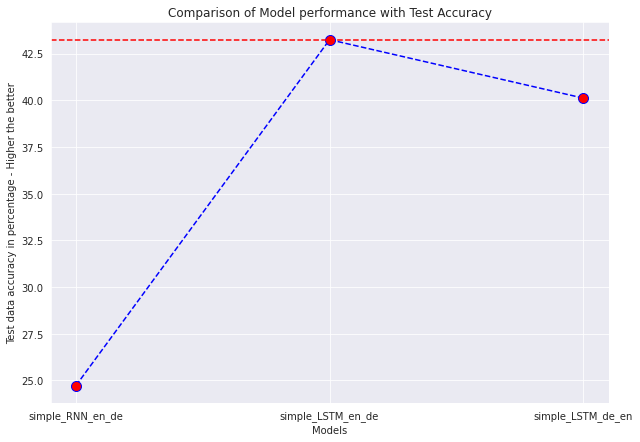

In [ ]:
#Coverting % values into float
df_summary_int = df_summary.copy()
numeric_cols = ['Test Accuracy','Validation Accuracy','Train Accuracy']
for i in numeric_cols:
  df_summary_int[i] = df_summary_int[i].str.rstrip("%").astype(float)
#Plotting a graph for model comparison
plt.figure(figsize=(10,7))
plt.plot(df_summary_int['Model'],df_summary_int['Test Accuracy'],color='blue', linestyle='dashed', marker='o', markerfacecolor='red', markersize=10)
plt.title('Comparison of Model performance with Test Accuracy')
plt.xlabel('Models')
plt.ylabel('Test data accuracy in percentage - Higher the better')
plt.axhline(y = 43.25, color = 'r', linestyle = '--')
plt.show()

#### Conclusion

1.   We were able to import all three given datasets and created a corpus out of it.
2.   Performed all data cleansing that is required
3.   Pre processing of data has been performed (Tokenization, Sequencing and Padding)
4.   Designed, Trained and Tested simple RNN & LSTM model (bilingual)
5.   With basic models, we were able to predict few words correctly and further tuning will be performed as part of Milestone 2

In [ ]:
#Fetching summary until milestone 1 in pickle file
summary_until_milestone2 = "/content/drive/MyDrive/Learning/summary_until_milestone2.pkl"
#summary_until_milestone1 = "/content/drive/MyDrive/Learning/summary_until_milestone1.pkl"
#function to load pickle file to df
def load_pickle_file(filename):
    df = pd.read_pickle(filename)
    return df
#df_summary = load_pickle_file(summary_until_milestone1)
df_summary = load_pickle_file(summary_until_milestone2)

In [ ]:
sample_size = 100000
X_train,X_test,Y_train,Y_test,X_val,Y_val = split_input_target(sample_size,'regular')
X_train_proc,X_test_proc,X_val_proc,eng_MaxLength,eng_VocabSize,eng_WordIndex,eng_Tokenizer,eng_TokenizedStrings = tokenize_seq_pad(X_train, X_test, X_val, word_reduction_limit, 'en')
Y_train_proc,Y_test_proc,Y_val_proc,ger_MaxLength,ger_VocabSize,ger_WordIndex,ger_Tokenizer,ger_TokenizedStrings = tokenize_seq_pad(Y_train, Y_test, Y_val, word_reduction_limit, 'de')
#Reshaping the vaues to get three dimensional shapes
X_tr_reshaped = X_train_proc.reshape(X_train_proc.shape[0],X_train_proc.shape[1],1)
X_te_reshaped = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1],1)
X_va_reshaped = X_val_proc.reshape(X_val_proc.shape[0], X_val_proc.shape[1],1)
Y_tr_reshaped = Y_train_proc.reshape(Y_train_proc.shape[0],Y_train_proc.shape[1],1)
Y_te_reshaped = Y_test_proc.reshape(Y_test_proc.shape[0], Y_test_proc.shape[1],1)
Y_va_reshaped = Y_val_proc.reshape(Y_val_proc.shape[0], Y_val_proc.shape[1],1)

Shape of X_train is : (64000,)
Shape of X_test is : (20000,)
Shape of X_validation is : (16000,)
Shape of Y_train is : (64000,)
Shape of Y_test is : (20000,)
Shape of Y_validation is : (16000,)
----------------------------------------------------------------------------------------------------
Printing Details for English language:
Below are the details after performing tokenization, sequencing and padding:
Max token length : 10
Vocab Count : 29871
Longest word : kommunikationswissenschaftler
Length of longest word : 29
Printing random sentence and corresponding padded tokens:
Below is the original sentence:
hope really does tend to get in the way
Below is the padded tokens for the above sentence
[ 214  159   63 5993    3   83    6    1  146    0]
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
Printing Details for German language:
Be

###  Creating embeddings with GloVe pre-trained vectors

In [ ]:
#Creating embedding index from Glove (Pre-trained word vectors)
glove_embeddings_index = {}
with open('/content/drive/MyDrive/Learning/glove.6B.300d.txt','r') as file:
  for line in tqdm(file):
    values = line.split()
    word = values[0]
    try:
      coefs = np.array(values[1:],'float32')
      glove_embeddings_index[word]=coefs
    except ValueError:
      pass
  file.close()
key = list(glove_embeddings_index.keys())[0]
glove_dim = len(glove_embeddings_index[key]) 

0it [00:00, ?it/s]

In [ ]:
#Creating weight matrix for english
eng_glove_data = np.zeros((eng_VocabSize+1, glove_dim))
for w, i in eng_WordIndex.items():
  temp_idx = glove_embeddings_index.get(w)
  if temp_idx is not None:
    eng_glove_data[i, :]= temp_idx
#Creating weight matrix for german
ger_glove_data = np.zeros((ger_VocabSize+1, glove_dim))
for w, i in ger_WordIndex.items():
  temp_idx = glove_embeddings_index.get(w)
  if temp_idx is not None:
    ger_glove_data[i, :]= temp_idx
#Printing Embedding Dimension
print('Embedding dimension of German embedding is',len(ger_glove_data[0]))
print('Embedding dimension of English embedding is',len(eng_glove_data[0]))

Embedding dimension of German embedding is 300
Embedding dimension of English embedding is 300


###  Visualization of GloVe pre-trained vectors

In [ ]:
# Verifying similar words from the pretrained embeddings
def find_similar_word(emmbedes):
  nearest = sorted(glove_embeddings_index.keys(), key=lambda word: spatial.distance.euclidean(glove_embeddings_index[word], emmbedes))
  return nearest
eng_similar_words = {}
ger_similar_words = {}
count  = 0
for i, w in enumerate(eng_freq):
  ger_word = ger_freq[i]
  eng_similar_words[w] = find_similar_word(glove_embeddings_index[w])[0:5]
  ger_similar_words[ger_word] = find_similar_word(glove_embeddings_index[ger_word])[0:5]
  count +=1
  if count > 4:
    break
eng_similar_words, ger_similar_words

({'the': ['the', 'which', 'same', 'of', 'part'],
  'is': ['is', 'now', 'this', 'it', 'comes'],
  'to': ['to', 'able', 'help', 'take', 'would'],
  'of': ['of', 'the', 'part', 'same', 'addition'],
  'a': ['a', 'another', 'this', 'one', 'same']},
 {'die': ['die', 'dying', 'dead', 'anyway', 'unfortunately'],
  'der': ['der', 'und', 'spiegel', 'van', 'deutschen'],
  'ist': ['ist', 'oly-2004-fhockey', 'oly-2004-cycling', 'gweye', '24aou94'],
  'das': ['das', 'buch', '„', 'sunder', 'neves'],
  'sie': ['sie', 'doo_mah', 'sloht', 'oly-2004-cycling', 'gweye']})

In [ ]:
#Loading GloVe Embeddings into dataframe for visualization
words = list(glove_embeddings_index.keys())
vectors = [glove_embeddings_index[word] for word in words]
embed_df =  (pd.DataFrame(vectors, index= words).transpose())
embed_df.head()

the         ,         .        of        to       and       in  \
0  0.046560 -0.255390 -0.125590 -0.076947 -0.257560  0.038466 -0.44399   
1  0.213180 -0.257230  0.013630 -0.021211 -0.057132 -0.039792  0.12817   
2 -0.007436  0.131690  0.103060  0.212710 -0.671900  0.082747 -0.25247   
3 -0.458540 -0.042688 -0.101230 -0.722320 -0.380820 -0.389230 -0.18582   
4 -0.035639  0.218170  0.098128 -0.139880 -0.364210 -0.214310 -0.16614   

          a         "        's  ...  sigarms    katuna      aqm   1.3775  \
0 -0.297120  0.694700 -0.001272  ...  0.14649 -0.030013  0.46348  0.71376   
1  0.094049  0.221840  0.365140  ... -0.47266  0.246260 -0.42811 -0.56625   
2 -0.096662  0.105260 -0.077363  ...  0.17144  0.068192  0.45750 -0.18468   
3 -0.344000  0.012382 -0.265590  ...  0.26431  0.089033  0.25317  0.30104   
4 -0.184830 -0.255800  0.179870  ... -0.13895 -0.199770  0.58327 -0.56443   

   corythosaurus    chanty    kronik   rolonda  zsombor  sandberger  
0       0.886490  0.392700  0.136790  0.075713  0.81451    0.429191  
1      -0.095745 -0.022505 -0.139090 -0.040502 -0.36221   -0.296897  
2       0.189610  0.304580 -0.360890  0.183450  0.31186    0.150110  
3       0.012919  0.187990  0.079864  0.512300  0.81381    0.245201  
4      -0.409250  0.141180  0.321490 -0.228560  0.18852   -0.003520  

[5 rows x 400000 columns]

In [ ]:
#Defining function to extract top 100 embedding vectors
def top100_embed_vectors(word_index):
  top100_embed_vectors ={}
  count = 0
  for word in word_index:
    if word != 'sos' and word != 'eos':
      try:
        top100_embed_vectors[word] = embed_df[word]
        count +=1
      except:
        continue
      if count == 100:
        break
  return top100_embed_vectors
#Extracting embedding vectors for top 100 German words
top100_embed_vectors_ger =  top100_embed_vectors(ger_WordIndex.keys())
top100_embed_vectors_ger_df = (pd.DataFrame(top100_embed_vectors_ger).transpose())
top100_embed_vectors_ger_df.head()

0         1        2         3         4         5        6    \
die  0.025042 -0.038148 -0.20158 -0.404050 -0.177940  0.099952  0.29869   
ist  0.060730 -0.693830 -0.35324  0.075721 -0.363000  0.213640 -0.65796   
der  0.399820  0.060408 -0.37447 -0.120190  0.059536 -0.096102 -0.43354   
das -0.041499  0.013428 -0.99504  0.305470 -0.154760 -0.529010 -0.66088   
sie -0.394940 -0.832470 -0.24329 -0.336890  0.347450 -0.254500 -0.64923   

         7         8        9    ...       290       291      292      293  \
die  0.60711 -0.245910 -0.65941  ... -0.039280 -0.176480  0.23647 -0.58212   
ist -0.20389 -0.014237  0.10504  ...  0.393420 -0.590610 -0.23894  0.19331   
der -0.55076 -0.478470 -0.92818  ... -0.195780 -0.068625 -0.10814 -0.50868   
das  0.70292 -0.670370 -0.97386  ... -0.300630  0.061412 -0.36083 -0.41544   
sie  0.40599 -0.425140  0.14910  ... -0.018444  0.860530  0.78732  0.41653   

          294       295       296       297       298      299  
die  0.072952 -0.002348 -0.097292 -0.167210  0.225080  0.16550  
ist -0.871560  0.078389  0.136410  0.147920 -0.085650  0.36010  
der  0.167080 -0.123410  0.817130  0.000014  0.371970  0.46349  
das  0.073304  0.069396  0.280540 -0.226910  0.022682  0.65969  
sie -0.133620  0.093812  0.473120  0.401760  0.200690  0.48555  

[5 rows x 300 columns]

In [ ]:
#Extracting embedding vectors for top 100 English words
top100_embed_vectors_eng = top100_embed_vectors(eng_WordIndex.keys())
top100_embed_vectors_eng_df = (pd.DataFrame(top100_embed_vectors_eng).transpose())
top100_embed_vectors_eng_df.head()

0         1         2        3         4         5         6    \
the  0.046560  0.213180 -0.007436 -0.45854 -0.035639  0.236430 -0.288360   
is  -0.174900  0.229560  0.249240 -0.20512 -0.122940  0.021297 -0.238150   
to  -0.257560 -0.057132 -0.671900 -0.38082 -0.364210 -0.082155 -0.010955   
of  -0.076947 -0.021211  0.212710 -0.72232 -0.139880 -0.122340 -0.175210   
a   -0.297120  0.094049 -0.096662 -0.34400 -0.184830 -0.123290 -0.116560   

          7         8       9    ...       290      291       292       293  \
the  0.215210 -0.134860 -1.6413  ... -0.013064 -0.29686 -0.079913  0.195000   
is   0.137370 -0.089130 -2.0607  ...  0.313570 -0.13407  0.184650  0.234260   
to  -0.082047  0.460560 -1.8477  ... -0.012806 -0.59707  0.317340 -0.252670   
of   0.121370 -0.070866 -1.5721  ... -0.366730 -0.38603  0.302900  0.015747   
a   -0.099692  0.172650 -1.6386  ...  0.075972 -0.42426 -0.396700  0.326830   

          294       295       296       297       298       299  
the  0.031549  0.285060 -0.087461  0.009061 -0.209890  0.053913  
is   0.076272  0.105020  0.215210 -0.241310 -0.404020  0.054744  
to   0.543840  0.063007 -0.049795 -0.160430  0.046744 -0.070621  
of   0.340360  0.478410  0.068617  0.183510 -0.291830 -0.046533  
a    0.620490  0.347190  0.269520  0.059717 -0.228530  0.296020  

[5 rows x 300 columns]

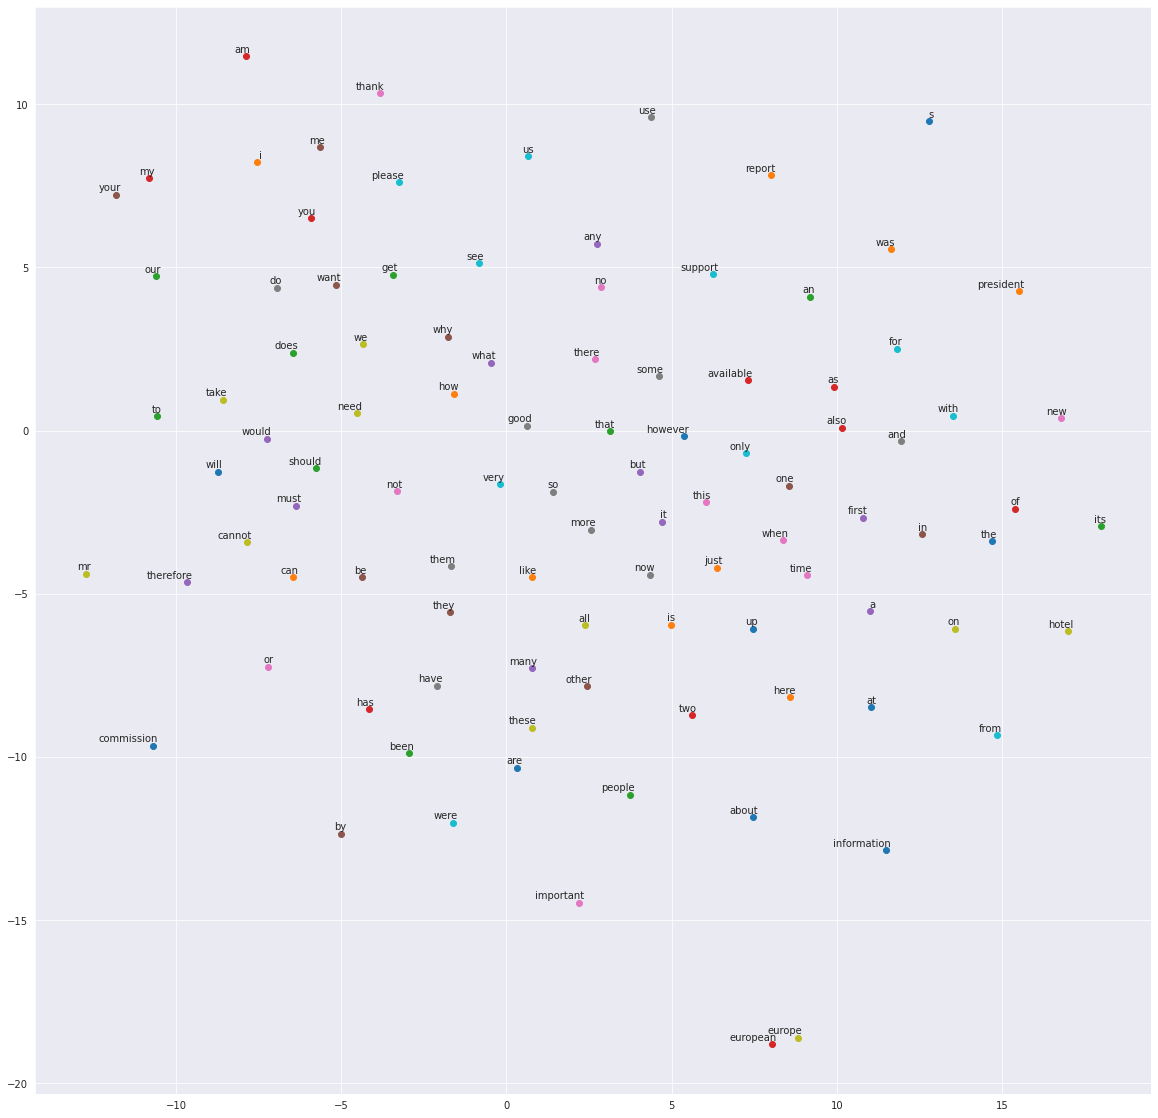

In [ ]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.manifold import TSNE
#Defining function to generate TSNE model for visualizing the relationship between embedding vectors
def generate_tsne_model(top100_embed, lang_name):
  tsne_model = TSNE(n_components=2, random_state=32)
  new_values= tsne_model.fit_transform(top100_embed)
  x = []
  y = []
  for value in new_values:
      x.append(value[0])
      y.append(value[1])
          
  plt.figure(figsize=(20, 20))
  labels = list(top100_embed.index)

  for i in range(len(x)):
      new_value = new_values[i]
      x = new_value[0]
      y = new_value[1]
          
      plt.scatter(x, y)
      plt.annotate(labels[i],
                      xy=(x, y),
                      xytext=(5, 2),
                      textcoords='offset points',
                      ha='right',
                      va='bottom')
      plt.savefig(f'{lang_name}_tsne.png')
  plt.show()
  plt.close()
#Generating TSNE visualization for English word embeddings
generate_tsne_model(top100_embed_vectors_eng_df, 'eng')

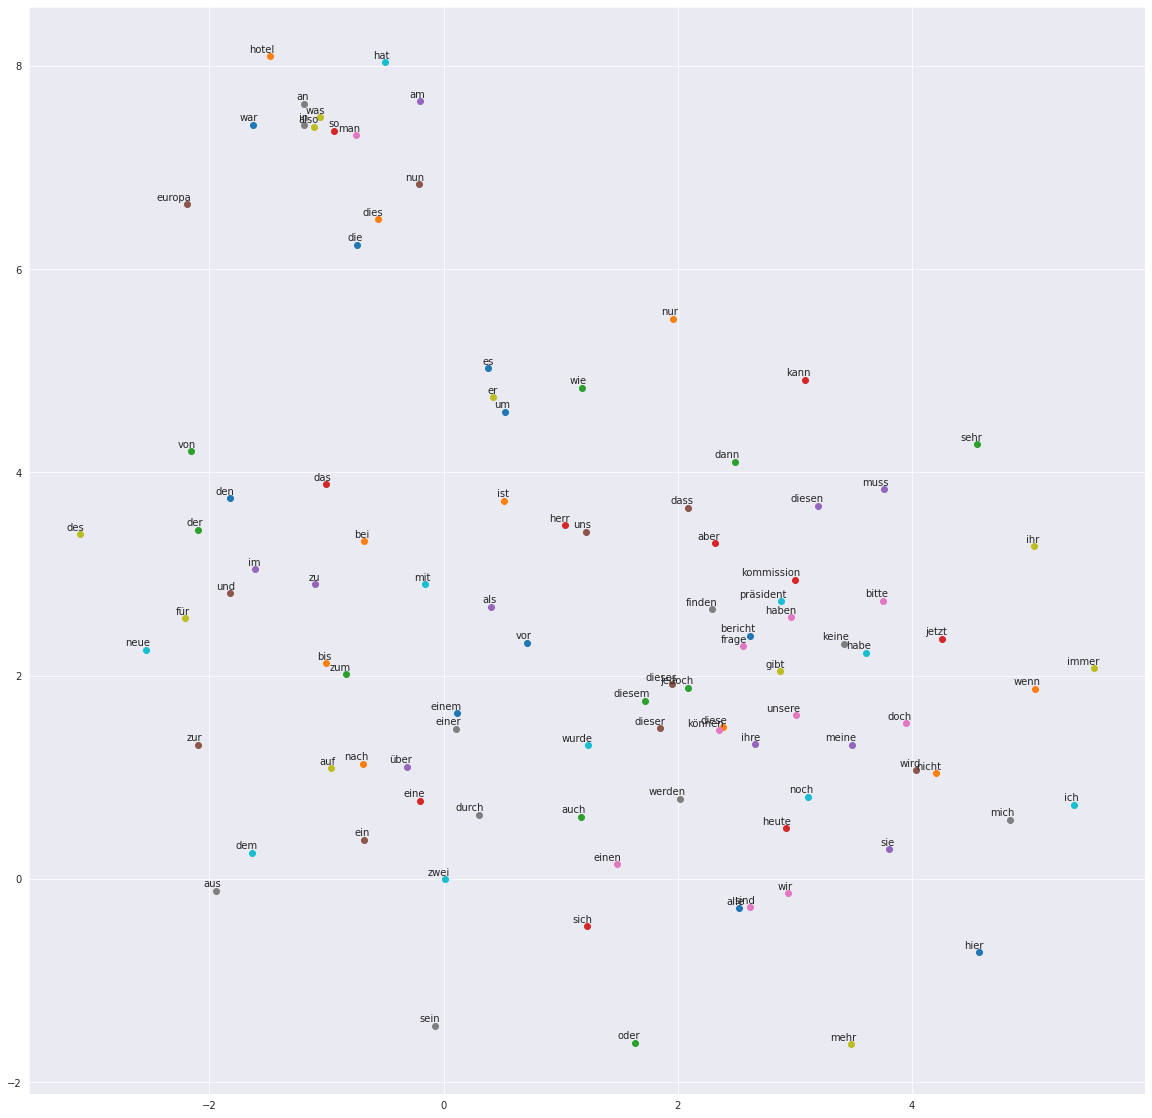

In [ ]:
#Generating TSNE visualization for German word embeddings
generate_tsne_model(top100_embed_vectors_ger_df, 'ger')

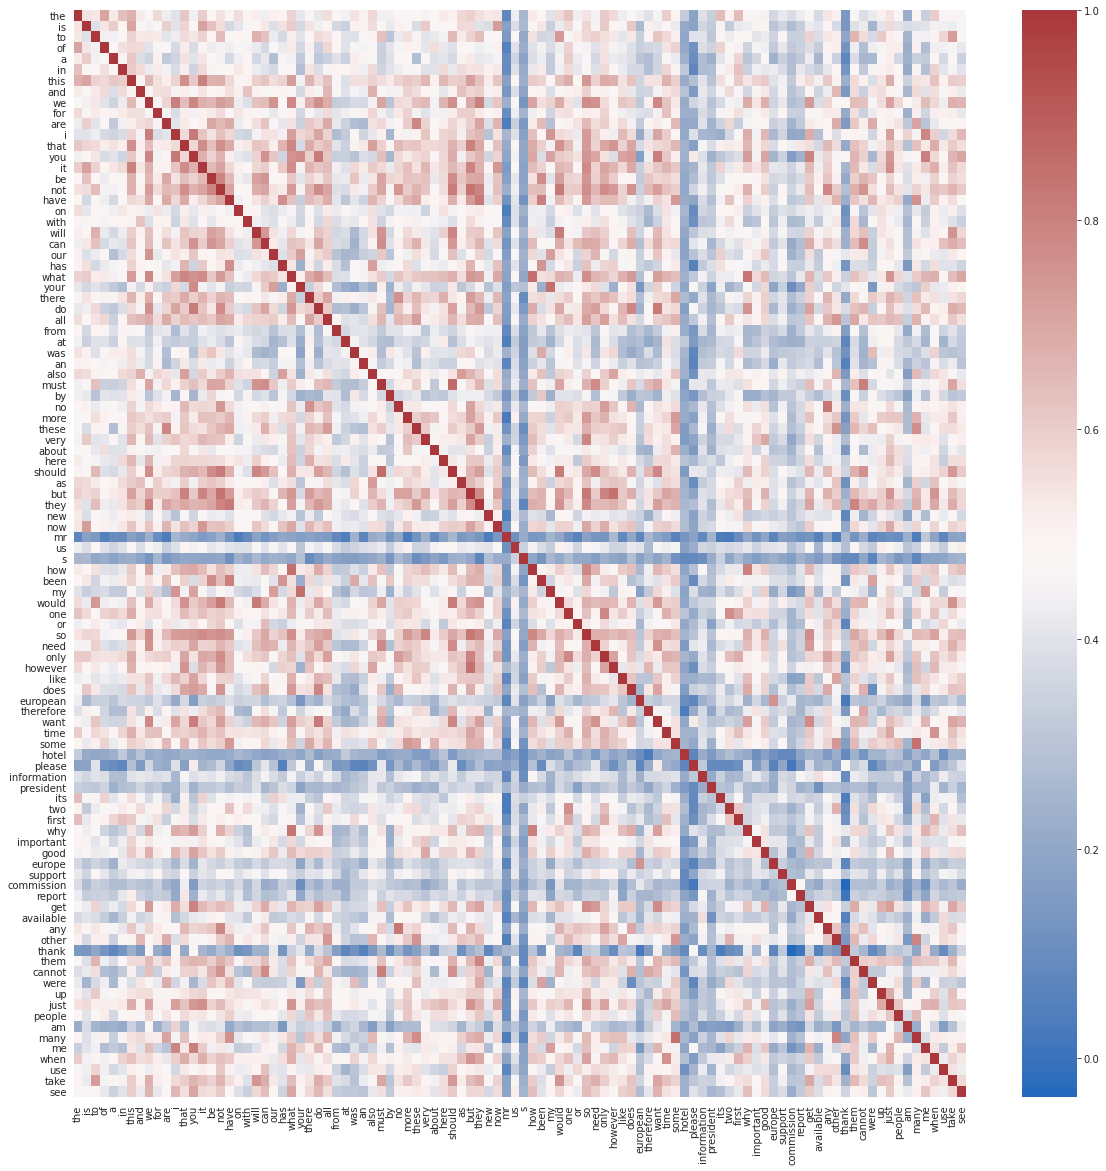

In [ ]:
#Heatmap for english word embeddings
similarities = cosine_similarity(top100_embed_vectors_eng_df, 
                                 top100_embed_vectors_eng_df)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=top100_embed_vectors_eng_df.index, 
            yticklabels=top100_embed_vectors_eng_df.index, cmap="vlag")
plt.show()

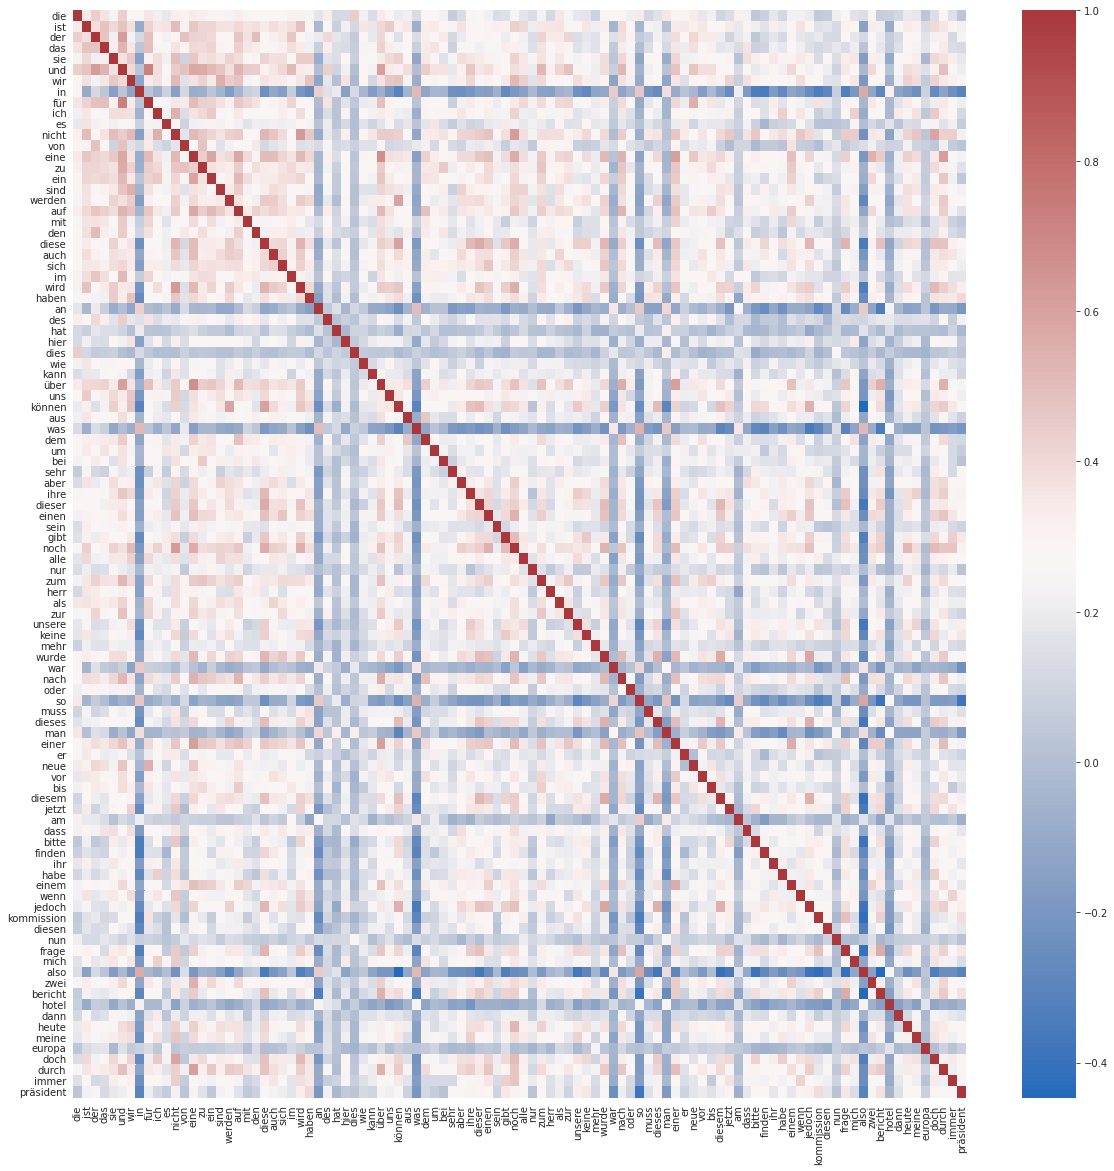

In [ ]:
#Heatmap for german word embeddings
similarities = cosine_similarity(top100_embed_vectors_ger_df, 
                                 top100_embed_vectors_ger_df)
fig, ax = plt.subplots(figsize=(20, 20))
sns.heatmap(ax=ax, 
            data=similarities,
            xticklabels=top100_embed_vectors_ger_df.index, 
            yticklabels=top100_embed_vectors_ger_df.index, cmap="vlag")
plt.show()

#### LSTM Model with Glove Embeddings

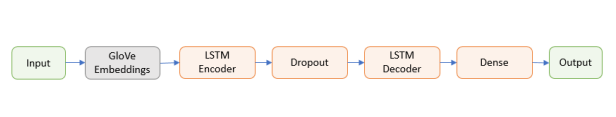

In [ ]:
LSTM_with_Glove_Diagram = Image.open(r"/content/drive/MyDrive/Learning/LSTM_with_Glove_Diagram.png")
LSTM_with_Glove_Diagram

#### LSTM Model with Glove Embeddings (English to German)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 10, 300)           8961600   
                                                                 
 lstm (LSTM)                 (None, 10, 256)           570368    
                                                                 
 dropout (Dropout)           (None, 10, 256)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 128)           197120    
                                                                 
 dense (Dense)               (None, 10, 50693)         6539397   
                                                                 
Total params: 16,268,485
Trainable params: 16,268,485
Non-trainable params: 0
_________________________________________________________________


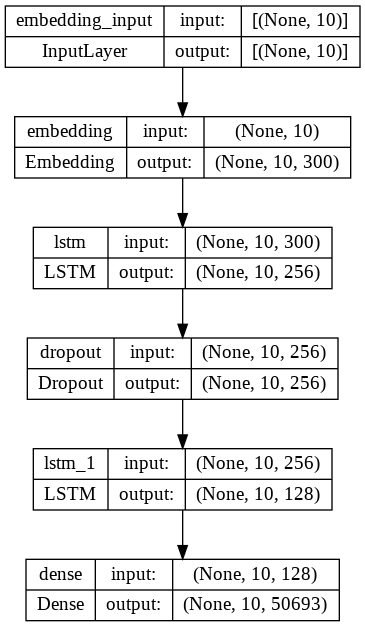

In [ ]:
glove_lstm_model = Sequential()
embedding_layer = Embedding(input_dim = eng_VocabSize+1, 
                            output_dim = glove_dim, weights = [eng_glove_data], 
                            input_length = word_reduction_limit)
glove_lstm_model.add(embedding_layer)
glove_lstm_model.add(LSTM(units=256,kernel_regularizer=l2(0.01), 
                          recurrent_regularizer=l2(0.01), 
                          bias_regularizer=l2(0.01), 
                          return_sequences=True ))
glove_lstm_model.add(Dropout(0.3))
glove_lstm_model.add(LSTM(units=128, return_sequences=True))
glove_lstm_model.add(Dense(ger_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.001)
glove_lstm_model.compile(optimizer=rms, loss= 'sparse_categorical_crossentropy', 
                         metrics=['accuracy'])
glove_lstm_model.summary()
glove_lstm_pic = "/content/drive/MyDrive/Learning/glove_lstm.png"
plot_model(glove_lstm_model, to_file= glove_lstm_pic, 
           show_shapes=True, show_layer_names=True)

In [ ]:
glove_lstm_model_name = 'lstm_with_GloVe_en_de'
batch_size = 256
epoch_val = 30
glove_lstm_model_history = train_and_fit_model(glove_lstm_model, epoch_val, batch_size, X_train_proc, Y_train_proc, X_val_proc, Y_val_proc, glove_lstm_model_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.44231, saving model to lstm_with_GloVe_en_de


250/250 - 46s - loss: 4.4009 - accuracy: 0.4196 - val_loss: 4.2677 - val_accuracy: 0.4423 - 46s/epoch - 182ms/step
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.44231
250/250 - 38s - loss: 4.3905 - accuracy: 0.4206 - val_loss: 4.2939 - val_accuracy: 0.4380 - 38s/epoch - 150ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.44231 to 0.44310, saving model to lstm_with_GloVe_en_de


250/250 - 46s - loss: 4.3808 - accuracy: 0.4212 - val_loss: 4.2566 - val_accuracy: 0.4431 - 46s/epoch - 185ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.44310
250/250 - 38s - loss: 4.3722 - accuracy: 0.4218 - val_loss: 4.2706 - val_accuracy: 0.4423 - 38s/epoch - 152ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.44310 to 0.44376, saving model to lstm_with_GloVe_en_de


250/250 - 45s - loss: 4.3627 - accuracy: 0.4225 - val_loss: 4.2612 - val_accuracy: 0.4438 - 45s/epoch - 180ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.44376
250/250 - 38s - loss: 4.3514 - accuracy: 0.4228 - val_loss: 4.2696 - val_accuracy: 0.4429 - 38s/epoch - 151ms/step
Epoch 7/30

Epoch 7: val_accuracy did not improve from 0.44376
250/250 - 38s - loss: 4.3384 - accuracy: 0.4236 - val_loss: 4.2588 - val_accuracy: 0.4437 - 38s/epoch - 150ms/step
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.44376
250/250 - 38s - loss: 4.3270 - accuracy: 0.4243 - val_loss: 4.2869 - val_accuracy: 0.4403 - 38s/epoch - 150ms/step


Printing accuracy details for lstm_with_GloVe_en_de
Test Accuracy: 44.58%
Validation Accuracy: 44.38%
Train Accuracy: 42.68%


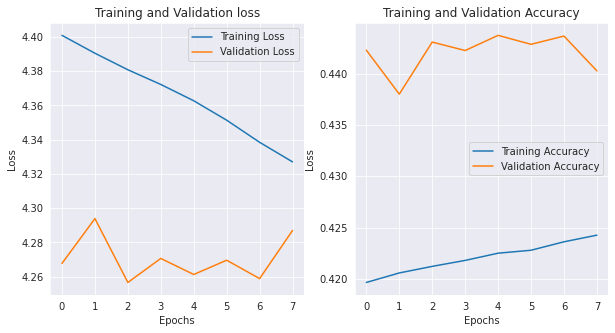

In [ ]:
load_trained_lstm_glove_en_de = print_and_store_accuracy(glove_lstm_model_name,X_train_proc,X_val_proc,X_test_proc,Y_train_proc,Y_val_proc,Y_test_proc)
plot_results(glove_lstm_model_history)

In [ ]:
location_LSTM_GloVe_en_de = '/content/drive/MyDrive/Learning/lstm_with_GloVe_en_de.h5'
load_trained_lstm_glove_en_de = load_and_display_accuracy(location_LSTM_GloVe_en_de,X_train_proc,X_val_proc,X_test_proc,Y_train_proc,Y_val_proc,Y_test_proc)

Printing accuracy details for lstm_with_GloVe_en_de
Test Accuracy: 44.58%
Validation Accuracy: 44.38%
Train Accuracy: 42.68%


In [ ]:
lstm_glove_en_de_predicted_df,df_summary = predict_and_print_top_20(load_trained_lstm_glove_en_de,X_test_proc, X_test, Y_test, ger_Tokenizer)
lstm_glove_en_de_predicted_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0       simple_RNN_en_de        24.72%              24.96%         34.70%   
1      simple_LSTM_en_de        43.25%              43.18%         40.72%   
2      simple_LSTM_de_en        40.12%              40.07%         45.58%   
3  lstm_with_GloVe_en_de        44.58%              44.38%         42.68%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69  
3      7.69             0.28         0.72

###LSTM Model with Glove Embeddings (English to German) - Observation


1.   Model was able to predict one of the sentences 72% correctly from the 20 samples that we took for prediction. Improvement observed in accuracy too while comparing Simple models.
2.   With Glove Embeddings, model has understanding of relationship between tokens and so we can see better prediction comparing to Simple models.
3.   Further exploration to be done with BiDirectional LSTM and other advanced mechanism (like Attention, Encoder/Decoder)



### LSTM Model with Glove Embeddings (German to English)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 10, 300)           15207900  
                                                                 
 lstm_2 (LSTM)               (None, 10, 256)           570368    
                                                                 
 dropout_1 (Dropout)         (None, 10, 256)           0         
                                                                 
 lstm_3 (LSTM)               (None, 10, 128)           197120    
                                                                 
 dense_1 (Dense)             (None, 10, 29872)         3853488   
                                                                 
Total params: 19,828,876
Trainable params: 19,828,876
Non-trainable params: 0
_________________________________________________________________


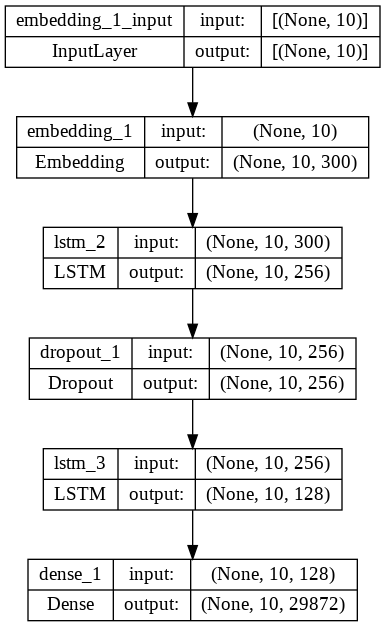

In [ ]:
glove_lstm_model_de_en = Sequential()
embedding_layer = Embedding(input_dim = ger_VocabSize+1, output_dim = glove_dim, 
                            weights = [ger_glove_data], 
                            input_length = word_reduction_limit)
glove_lstm_model_de_en.add(embedding_layer)
glove_lstm_model_de_en.add(LSTM(units=256,kernel_regularizer=l2(0.01), 
                                recurrent_regularizer=l2(0.01), 
                                bias_regularizer=l2(0.01), 
                                return_sequences=True ))
glove_lstm_model_de_en.add(Dropout(0.3))
glove_lstm_model_de_en.add(LSTM(units=128, return_sequences=True))
glove_lstm_model_de_en.add(Dense(eng_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.001)
glove_lstm_model_de_en.compile(optimizer=rms, 
                               loss= 'sparse_categorical_crossentropy', 
                               metrics=['accuracy'])
glove_lstm_model_de_en.summary()
glove_lstm_de_eb_pic = "/content/drive/MyDrive/Learning/glove_lstm_de_en.png"
plot_model(glove_lstm_model_de_en, to_file= glove_lstm_de_eb_pic, 
           show_shapes=True, show_layer_names=True)

In [ ]:
glove_lstm_de_en_name = 'LSTM_with_GloVe_de_en'
batch_size = 256
epoch_val = 30
glove_lstm_de_en_history = train_and_fit_model(glove_lstm_model_de_en, epoch_val, batch_size, Y_train_proc, X_train_proc, Y_val_proc, X_val_proc, glove_lstm_de_en_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.32281, saving model to LSTM_with_GloVe_de_en


250/250 - 35s - loss: 8.2969 - accuracy: 0.2783 - val_loss: 6.5787 - val_accuracy: 0.3228 - 35s/epoch - 141ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.32281 to 0.33733, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 6.3278 - accuracy: 0.3062 - val_loss: 5.6124 - val_accuracy: 0.3373 - 31s/epoch - 125ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.33733 to 0.34132, saving model to LSTM_with_GloVe_de_en


250/250 - 33s - loss: 5.5491 - accuracy: 0.3175 - val_loss: 5.1015 - val_accuracy: 0.3413 - 33s/epoch - 131ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.34132 to 0.36069, saving model to LSTM_with_GloVe_de_en


250/250 - 32s - loss: 5.1279 - accuracy: 0.3320 - val_loss: 4.7976 - val_accuracy: 0.3607 - 32s/epoch - 129ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.36069 to 0.37054, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.9675 - accuracy: 0.3468 - val_loss: 4.7244 - val_accuracy: 0.3705 - 31s/epoch - 124ms/step
Epoch 6/30

Epoch 6: val_accuracy improved from 0.37054 to 0.37480, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.8828 - accuracy: 0.3562 - val_loss: 4.6800 - val_accuracy: 0.3748 - 31s/epoch - 124ms/step
Epoch 7/30

Epoch 7: val_accuracy improved from 0.37480 to 0.38416, saving model to LSTM_with_GloVe_de_en


250/250 - 33s - loss: 4.8099 - accuracy: 0.3636 - val_loss: 4.6285 - val_accuracy: 0.3842 - 33s/epoch - 130ms/step
Epoch 8/30

Epoch 8: val_accuracy improved from 0.38416 to 0.38881, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.7461 - accuracy: 0.3713 - val_loss: 4.5859 - val_accuracy: 0.3888 - 31s/epoch - 124ms/step
Epoch 9/30

Epoch 9: val_accuracy improved from 0.38881 to 0.39276, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.6896 - accuracy: 0.3774 - val_loss: 4.5622 - val_accuracy: 0.3928 - 31s/epoch - 125ms/step
Epoch 10/30

Epoch 10: val_accuracy improved from 0.39276 to 0.39714, saving model to LSTM_with_GloVe_de_en


250/250 - 32s - loss: 4.6381 - accuracy: 0.3823 - val_loss: 4.5267 - val_accuracy: 0.3971 - 32s/epoch - 129ms/step
Epoch 11/30

Epoch 11: val_accuracy improved from 0.39714 to 0.40204, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.5899 - accuracy: 0.3874 - val_loss: 4.4957 - val_accuracy: 0.4020 - 31s/epoch - 125ms/step
Epoch 12/30

Epoch 12: val_accuracy improved from 0.40204 to 0.40469, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.5458 - accuracy: 0.3912 - val_loss: 4.4732 - val_accuracy: 0.4047 - 31s/epoch - 125ms/step
Epoch 13/30

Epoch 13: val_accuracy improved from 0.40469 to 0.40804, saving model to LSTM_with_GloVe_de_en


250/250 - 33s - loss: 4.5041 - accuracy: 0.3950 - val_loss: 4.4573 - val_accuracy: 0.4080 - 33s/epoch - 131ms/step
Epoch 14/30

Epoch 14: val_accuracy improved from 0.40804 to 0.40938, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.4649 - accuracy: 0.3975 - val_loss: 4.4398 - val_accuracy: 0.4094 - 31s/epoch - 125ms/step
Epoch 15/30

Epoch 15: val_accuracy improved from 0.40938 to 0.41074, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.4295 - accuracy: 0.4002 - val_loss: 4.4406 - val_accuracy: 0.4107 - 31s/epoch - 124ms/step
Epoch 16/30

Epoch 16: val_accuracy improved from 0.41074 to 0.41169, saving model to LSTM_with_GloVe_de_en


250/250 - 35s - loss: 4.3964 - accuracy: 0.4024 - val_loss: 4.4122 - val_accuracy: 0.4117 - 35s/epoch - 140ms/step
Epoch 17/30

Epoch 17: val_accuracy improved from 0.41169 to 0.41449, saving model to LSTM_with_GloVe_de_en


250/250 - 32s - loss: 4.3641 - accuracy: 0.4050 - val_loss: 4.4193 - val_accuracy: 0.4145 - 32s/epoch - 127ms/step
Epoch 18/30

Epoch 18: val_accuracy did not improve from 0.41449
250/250 - 24s - loss: 4.3347 - accuracy: 0.4069 - val_loss: 4.3991 - val_accuracy: 0.4139 - 24s/epoch - 95ms/step
Epoch 19/30

Epoch 19: val_accuracy improved from 0.41449 to 0.41569, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.3052 - accuracy: 0.4091 - val_loss: 4.3988 - val_accuracy: 0.4157 - 31s/epoch - 125ms/step
Epoch 20/30

Epoch 20: val_accuracy did not improve from 0.41569
250/250 - 24s - loss: 4.2787 - accuracy: 0.4111 - val_loss: 4.3870 - val_accuracy: 0.4154 - 24s/epoch - 95ms/step
Epoch 21/30

Epoch 21: val_accuracy improved from 0.41569 to 0.41750, saving model to LSTM_with_GloVe_de_en


250/250 - 33s - loss: 4.2539 - accuracy: 0.4127 - val_loss: 4.3991 - val_accuracy: 0.4175 - 33s/epoch - 130ms/step
Epoch 22/30

Epoch 22: val_accuracy did not improve from 0.41750
250/250 - 24s - loss: 4.2299 - accuracy: 0.4143 - val_loss: 4.3876 - val_accuracy: 0.4157 - 24s/epoch - 94ms/step
Epoch 23/30

Epoch 23: val_accuracy improved from 0.41750 to 0.41818, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.2071 - accuracy: 0.4162 - val_loss: 4.3829 - val_accuracy: 0.4182 - 31s/epoch - 125ms/step
Epoch 24/30

Epoch 24: val_accuracy improved from 0.41818 to 0.41950, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.1845 - accuracy: 0.4177 - val_loss: 4.3702 - val_accuracy: 0.4195 - 31s/epoch - 124ms/step
Epoch 25/30

Epoch 25: val_accuracy improved from 0.41950 to 0.42051, saving model to LSTM_with_GloVe_de_en


250/250 - 31s - loss: 4.1638 - accuracy: 0.4196 - val_loss: 4.4122 - val_accuracy: 0.4205 - 31s/epoch - 126ms/step
Epoch 26/30

Epoch 26: val_accuracy did not improve from 0.42051
250/250 - 24s - loss: 4.1417 - accuracy: 0.4212 - val_loss: 4.3570 - val_accuracy: 0.4189 - 24s/epoch - 95ms/step
Epoch 27/30

Epoch 27: val_accuracy did not improve from 0.42051
250/250 - 24s - loss: 4.1227 - accuracy: 0.4226 - val_loss: 4.3632 - val_accuracy: 0.4204 - 24s/epoch - 95ms/step
Epoch 28/30

Epoch 28: val_accuracy improved from 0.42051 to 0.42096, saving model to LSTM_with_GloVe_de_en


250/250 - 33s - loss: 4.1028 - accuracy: 0.4243 - val_loss: 4.3551 - val_accuracy: 0.4210 - 33s/epoch - 131ms/step
Epoch 29/30

Epoch 29: val_accuracy did not improve from 0.42096
250/250 - 24s - loss: 4.0846 - accuracy: 0.4256 - val_loss: 4.3603 - val_accuracy: 0.4201 - 24s/epoch - 95ms/step
Epoch 30/30

Epoch 30: val_accuracy did not improve from 0.42096
250/250 - 24s - loss: 4.0665 - accuracy: 0.4273 - val_loss: 4.3510 - val_accuracy: 0.4178 - 24s/epoch - 96ms/step


Printing accuracy details for LSTM_with_GloVe_de_en
Test Accuracy: 42.33%
Validation Accuracy: 42.10%
Train Accuracy: 42.97%


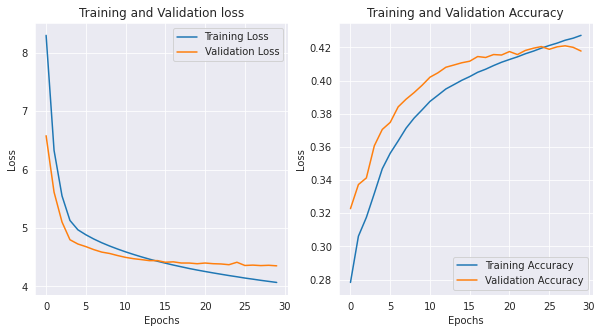

In [ ]:
load_trained_lstm_glove_de_en = print_and_store_accuracy(glove_lstm_de_en_name,Y_train_proc,Y_val_proc,Y_test_proc,X_train_proc,X_val_proc,X_test_proc)
plot_results(glove_lstm_de_en_history)

In [ ]:
location_LSTM_GloVe_de_en = '/content/drive/MyDrive/Learning/LSTM_with_GloVe_de_en.h5'
load_trained_lstm_glove_de_en = load_and_display_accuracy(location_LSTM_GloVe_de_en,Y_train_proc,Y_val_proc,Y_test_proc,X_train_proc,X_val_proc,X_test_proc)

Printing accuracy details for LSTM_with_GloVe_de_en
Test Accuracy: 42.33%
Validation Accuracy: 42.10%
Train Accuracy: 42.97%


In [ ]:
lstm_glove_de_en_predicted_df,df_summary = predict_and_print_top_20(load_trained_lstm_glove_de_en,Y_test_proc, Y_test, X_test, eng_Tokenizer)
lstm_glove_de_en_predicted_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0       simple_RNN_en_de        24.72%              24.96%         34.70%   
1      simple_LSTM_en_de        43.25%              43.18%         40.72%   
2      simple_LSTM_de_en        40.12%              40.07%         45.58%   
3  lstm_with_GloVe_en_de        44.58%              44.38%         42.68%   
4  LSTM_with_GloVe_de_en        42.33%              42.10%         42.97%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69  
3      7.69             0.28         0.72  
4      3.55              0.3         0.57

###LSTM Model with Glove Embeddings (German to English) - Observation


1.   With introduction of GloVe embeddings, 2% Accuracy improvement observed while comparing to same language pairs with simple LSTM.
2.   We couldn't observe predictions better than similar model with opposite language pairs (English - German)
3.   Further exploration to be done with BiDirectional LSTM and other advanced mechanism (like Attention, Encoder/Decoder)



#### Hyperparameter Tuning via Keras Tuner

In [ ]:
def model_builder(hp):
  model = Sequential()
  embedding_layer = Embedding(input_dim = ger_VocabSize+1,output_dim = glove_dim, input_length = word_reduction_limit)
  model.add(embedding_layer)
  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
  model.add(Bidirectional(LSTM(units=hp_units,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01),
                               bias_regularizer=l2(0.01),return_sequences=True )))
  model.add(Dropout(0.3))
  model.add(Dense(eng_VocabSize+1, activation='softmax'))
  # Tune the learning rate for the optimizer
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])
  return model

In [ ]:
tuner = kt.Hyperband(model_builder, objective='val_accuracy', 
                     max_epochs=10, factor=3)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
tuner.search(X_train_proc, Y_train_proc, epochs=10, 
             validation_data=(X_val_proc, Y_val_proc), callbacks=[stop_early])
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

Trial 30 Complete [00h 07m 27s]
val_accuracy: 0.34622499346733093

Best val_accuracy So Far: 0.34622499346733093
Total elapsed time: 02h 04m 25s


#### Hyperparameter Tuning via Keras Tuner - Observation


1.   With Hyperparamter tuning, we tried using Optimizer as Adam, however it's accuracy is lesser than our previously used Optimizer (RMSprop)
2.   Through, Hyperparameter tuning, we observed (learning rate of 0.01 is best option among all). We will incorporate it in our next models.



In [ ]:
print(f"""The hyperparameter search is complete. 
The optimal number of units in the first densely-connected layer is 
{best_hps.get('units')} 
and the optimal learning rate for the optimizer is 
{best_hps.get('learning_rate')}.""")

The hyperparameter search is complete. The optimal number of units in the first densely-connected layer is 128 
and the optimal learning rate for the optimizer is 0.01.


### Bidirectional LSTM



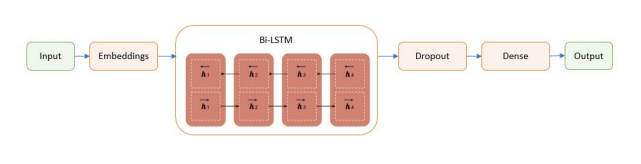

In [ ]:
Bidirectional_LSTM_diagram = Image.open(r"/content/drive/MyDrive/Learning/Bidirectional_LSTM_diagram.png")
Bidirectional_LSTM_diagram

#### Bidirectional LSTM (German to English)



Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 10, 300)           15207900  
                                                                 
 bidirectional_2 (Bidirectio  (None, 10, 256)          439296    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 10, 256)           0         
                                                                 
 dense_2 (Dense)             (None, 10, 29872)         7677104   
                                                                 
Total params: 23,324,300
Trainable params: 23,324,300
Non-trainable params: 0
_________________________________________________________________


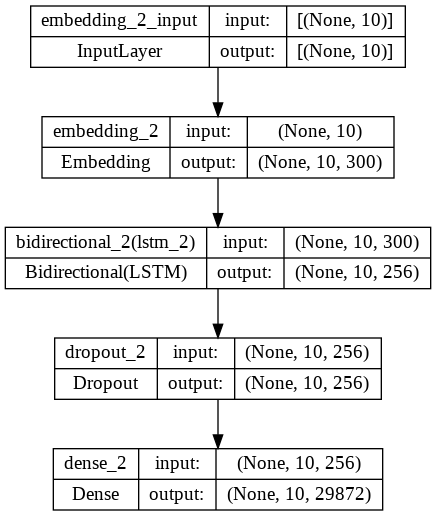

In [ ]:
bidirectional_LSTM_de_en = Sequential()
embedding_layer = Embedding(input_dim = ger_VocabSize+1,
                            output_dim = glove_dim, 
                            input_length = word_reduction_limit)
bidirectional_LSTM_de_en.add(embedding_layer)
bidirectional_LSTM_de_en.add(Bidirectional(LSTM(units=128,
                                                kernel_regularizer=l2(0.01), 
                                                recurrent_regularizer=l2(0.01), 
                                                bias_regularizer=l2(0.01),
                                                return_sequences=True )))
bidirectional_LSTM_de_en.add(Dropout(0.3))
bidirectional_LSTM_de_en.add(Dense(eng_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.01)
bidirectional_LSTM_de_en.compile(optimizer=rms, 
                                 loss= 'sparse_categorical_crossentropy', 
                                 metrics=['accuracy'])
bidirectional_LSTM_de_en.summary()
bidirectional_LSTM_de_en_pic = "/content/drive/MyDrive/Learning/bidirect_model_de_en.png"
plot_model(bidirectional_LSTM_de_en, to_file= bidirectional_LSTM_de_en_pic, 
           show_shapes=True, show_layer_names=True)

In [ ]:
bd_lstm_de_en_name = 'bidirectional_LSTM_de_en'
batch_size = 256
epoch_val = 30
bd_lstm_de_en_history = train_and_fit_model(bidirectional_LSTM_de_en, epoch_val, batch_size, Y_train_proc, X_train_proc, Y_val_proc, X_val_proc, bd_lstm_de_en_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.35001, saving model to bidirectional_LSTM_de_en


250/250 - 44s - loss: 6.4087 - accuracy: 0.3055 - val_loss: 5.1988 - val_accuracy: 0.3500 - 44s/epoch - 175ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.35001 to 0.38905, saving model to bidirectional_LSTM_de_en


250/250 - 40s - loss: 5.4540 - accuracy: 0.3488 - val_loss: 4.9005 - val_accuracy: 0.3891 - 40s/epoch - 159ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.38905 to 0.39469, saving model to bidirectional_LSTM_de_en


250/250 - 39s - loss: 5.2003 - accuracy: 0.3756 - val_loss: 4.9209 - val_accuracy: 0.3947 - 39s/epoch - 156ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.39469 to 0.40565, saving model to bidirectional_LSTM_de_en


250/250 - 41s - loss: 5.0361 - accuracy: 0.3869 - val_loss: 4.7888 - val_accuracy: 0.4056 - 41s/epoch - 165ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.40565
250/250 - 27s - loss: 4.9262 - accuracy: 0.3947 - val_loss: 4.7635 - val_accuracy: 0.4007 - 27s/epoch - 108ms/step
Epoch 6/30

Epoch 6: val_accuracy improved from 0.40565 to 0.40708, saving model to bidirectional_LSTM_de_en


250/250 - 39s - loss: 4.8436 - accuracy: 0.4005 - val_loss: 4.7455 - val_accuracy: 0.4071 - 39s/epoch - 157ms/step
Epoch 7/30

Epoch 7: val_accuracy improved from 0.40708 to 0.41161, saving model to bidirectional_LSTM_de_en


250/250 - 40s - loss: 4.7896 - accuracy: 0.4055 - val_loss: 4.6776 - val_accuracy: 0.4116 - 40s/epoch - 159ms/step
Epoch 8/30

Epoch 8: val_accuracy improved from 0.41161 to 0.41438, saving model to bidirectional_LSTM_de_en


250/250 - 39s - loss: 4.7623 - accuracy: 0.4090 - val_loss: 4.7246 - val_accuracy: 0.4144 - 39s/epoch - 157ms/step
Epoch 9/30

Epoch 9: val_accuracy improved from 0.41438 to 0.41771, saving model to bidirectional_LSTM_de_en


250/250 - 40s - loss: 4.7310 - accuracy: 0.4123 - val_loss: 4.6917 - val_accuracy: 0.4177 - 40s/epoch - 159ms/step
Epoch 10/30

Epoch 10: val_accuracy improved from 0.41771 to 0.42153, saving model to bidirectional_LSTM_de_en


250/250 - 39s - loss: 4.6954 - accuracy: 0.4165 - val_loss: 4.6834 - val_accuracy: 0.4215 - 39s/epoch - 156ms/step
Epoch 11/30

Epoch 11: val_accuracy improved from 0.42153 to 0.42320, saving model to bidirectional_LSTM_de_en


250/250 - 40s - loss: 4.6665 - accuracy: 0.4196 - val_loss: 4.6961 - val_accuracy: 0.4232 - 40s/epoch - 159ms/step
Epoch 12/30

Epoch 12: val_accuracy did not improve from 0.42320
250/250 - 27s - loss: 4.6421 - accuracy: 0.4229 - val_loss: 4.7538 - val_accuracy: 0.4169 - 27s/epoch - 108ms/step


Printing accuracy details for bidirectional_LSTM_de_en
Test Accuracy: 42.72%
Validation Accuracy: 42.32%
Train Accuracy: 43.47%


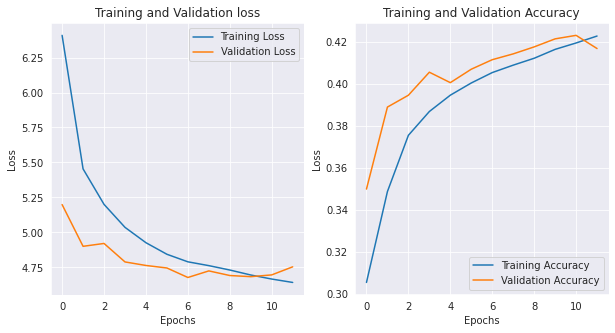

In [ ]:
trained_bd_lstm_de_en = print_and_store_accuracy(bd_lstm_de_en_name,Y_train_proc,Y_val_proc,Y_test_proc,X_train_proc,X_val_proc,X_test_proc)
plot_results(bd_lstm_de_en_history)

In [ ]:
bd_lstm_predicted_de_en_df,df_summary = predict_and_print_top_20(trained_bd_lstm_de_en,Y_test_proc, Y_test, X_test, eng_Tokenizer)
bd_lstm_predicted_de_en_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0          simple_RNN_en_de        24.72%              24.96%         34.70%   
1         simple_LSTM_en_de        43.25%              43.18%         40.72%   
2         simple_LSTM_de_en        40.12%              40.07%         45.58%   
3     lstm_with_GloVe_en_de        44.58%              44.38%         42.68%   
4     LSTM_with_GloVe_de_en        42.33%              42.10%         42.97%   
5  bidirectional_LSTM_de_en        42.72%              42.32%         43.47%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69  
3      7.69             0.28         0.72  
4      3.55              0.3         0.57  
5      6.39             0.45         0.89

#### Bidirectional LSTM (German to English) - Observation


1.   With introduction of Bi-directional LSTM, we could see model is able to predict one of the sentence with 88% accuracy (out of 20 samples).
2.   Overall meteor score has improved significantly comparing to the models reviewed so far.
3.   GloVe embedding can be tried along with Bi-directional LSTM to see if it improves the performance.




#### Bidirectional LSTM (English to German)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 10, 300)           8961600   
                                                                 
 bidirectional_3 (Bidirectio  (None, 10, 1024)         3330048   
 nal)                                                            
                                                                 
 dropout_3 (Dropout)         (None, 10, 1024)          0         
                                                                 
 dense_3 (Dense)             (None, 10, 50693)         51960325  
                                                                 
Total params: 64,251,973
Trainable params: 64,251,973
Non-trainable params: 0
_________________________________________________________________


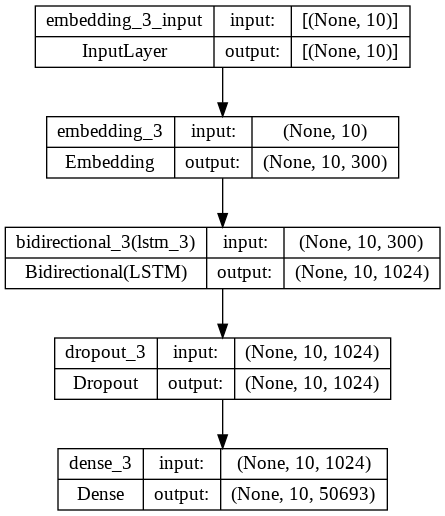

In [ ]:
bidirectional_LSTM = Sequential()
embedding_layer = Embedding(input_dim = eng_VocabSize+1,output_dim = glove_dim, input_length = word_reduction_limit)
bidirectional_LSTM.add(embedding_layer)
bidirectional_LSTM.add(Bidirectional(LSTM(units=512,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),return_sequences=True )))
bidirectional_LSTM.add(Dropout(0.3))
bidirectional_LSTM.add(Dense(ger_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.01)
bidirectional_LSTM.compile(optimizer=rms, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
bidirectional_LSTM.summary()
bidirectional_LSTM_pic = "/content/drive/MyDrive/Learning/bidirect_model_en_de.png"
plot_model(bidirectional_LSTM, to_file= bidirectional_LSTM_pic, show_shapes=True, show_layer_names=True)

In [ ]:
bd_lstm_name = 'bidirectional_LSTM_en_de'
batch_size = 256
epoch_val = 30
bd_lstm_history = train_and_fit_model(bidirectional_LSTM, epoch_val, batch_size, X_train_proc, Y_train_proc, X_val_proc, Y_val_proc, bd_lstm_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.36897, saving model to bidirectional_LSTM_en_de


250/250 - 118s - loss: 9.8666 - accuracy: 0.3001 - val_loss: 6.0685 - val_accuracy: 0.3690 - 118s/epoch - 473ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.36897 to 0.40471, saving model to bidirectional_LSTM_en_de


250/250 - 114s - loss: 6.8258 - accuracy: 0.3489 - val_loss: 5.5328 - val_accuracy: 0.4047 - 114s/epoch - 457ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.40471 to 0.41493, saving model to bidirectional_LSTM_en_de


250/250 - 116s - loss: 6.5274 - accuracy: 0.3678 - val_loss: 5.5533 - val_accuracy: 0.4149 - 116s/epoch - 464ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.41493
250/250 - 101s - loss: 6.3091 - accuracy: 0.3763 - val_loss: 5.6304 - val_accuracy: 0.4132 - 101s/epoch - 404ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.41493 to 0.42219, saving model to bidirectional_LSTM_en_de


250/250 - 114s - loss: 6.0998 - accuracy: 0.3830 - val_loss: 5.4597 - val_accuracy: 0.4222 - 114s/epoch - 454ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.42219
250/250 - 101s - loss: 6.0367 - accuracy: 0.3856 - val_loss: 5.6246 - val_accuracy: 0.4050 - 101s/epoch - 403ms/step
Epoch 7/30

Epoch 7: val_accuracy did not improve from 0.42219
250/250 - 100s - loss: 6.0126 - accuracy: 0.3895 - val_loss: 5.5680 - val_accuracy: 0.4158 - 100s/epoch - 399ms/step
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.42219
250/250 - 100s - loss: 6.0051 - accuracy: 0.3908 - val_loss: 5.6749 - val_accuracy: 0.4207 - 100s/epoch - 399ms/step
Epoch 9/30

Epoch 9: val_accuracy improved from 0.42219 to 0.42674, saving model to bidirectional_LSTM_en_de


250/250 - 114s - loss: 6.0067 - accuracy: 0.3921 - val_loss: 5.5665 - val_accuracy: 0.4267 - 114s/epoch - 458ms/step
Epoch 10/30

Epoch 10: val_accuracy did not improve from 0.42674
250/250 - 101s - loss: 6.0134 - accuracy: 0.3947 - val_loss: 5.6268 - val_accuracy: 0.4260 - 101s/epoch - 403ms/step


Printing accuracy details for bidirectional_LSTM_en_de
Test Accuracy: 42.96%
Validation Accuracy: 42.67%
Train Accuracy: 39.56%


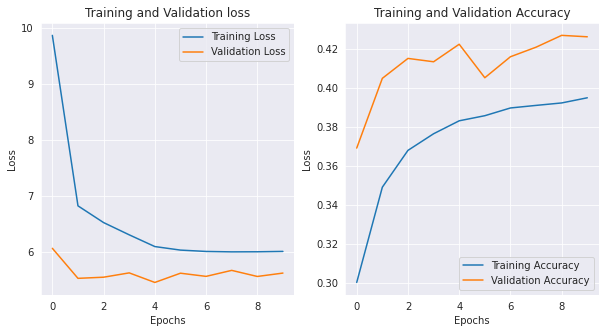

In [ ]:
trained_bd_lstm_en_de = print_and_store_accuracy(bd_lstm_name,X_train_proc,X_val_proc,X_test_proc,Y_train_proc,Y_val_proc,Y_test_proc)
plot_results(bd_lstm_history)

In [ ]:
bd_lstm_predicted_en_de_df,df_summary = predict_and_print_top_20(trained_bd_lstm_en_de,X_test_proc, X_test, Y_test, ger_Tokenizer)
bd_lstm_predicted_en_de_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy Train Accuracy  \
0          simple_RNN_en_de        24.72%              24.96%         34.70%   
1         simple_LSTM_en_de        43.25%              43.18%         40.72%   
2         simple_LSTM_de_en        40.12%              40.07%         45.58%   
3     lstm_with_GloVe_en_de        44.58%              44.38%         42.68%   
4     LSTM_with_GloVe_de_en        42.33%              42.10%         42.97%   
5  bidirectional_LSTM_de_en        42.72%              42.32%         43.47%   
6  bidirectional_LSTM_en_de        42.96%              42.67%         39.56%   

  SacreBleu METEOR - Average METEOR - Max  
0      5.57             0.35         0.68  
1      3.86             0.31         0.52  
2      6.78             0.29         0.69  
3      7.69             0.28         0.72  
4      3.55              0.3         0.57  
5      6.39             0.45         0.89  
6      5.27             0.27         0.71

#### Bidirectional LSTM (English to German) - Observation

1.   With introduction of Bi-directional LSTM, we could see model is able to predict one of the sentence with 71% accuracy (out of 20 samples).
2.   Overall test accuracy looks better among models with same language pairs.
3.   GloVe embedding can be tried along with Bi-directional LSTM to see if it improves the performance.




### Bidirectional LSTM with Glove

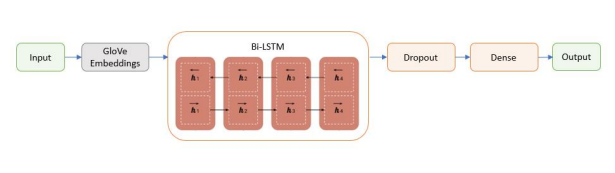

In [ ]:
Bidirectional_LSTM_with_Glove_diagram = Image.open(r"/content/drive/MyDrive/Learning/Bidirectional_LSTM_with_Glove_diagram.png")
Bidirectional_LSTM_with_Glove_diagram

#### Bidirectional LSTM with Glove (German to English)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 10, 300)           15207900  
                                                                 
 bidirectional_4 (Bidirectio  (None, 10, 256)          439296    
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 10, 256)           0         
                                                                 
 dense_4 (Dense)             (None, 10, 29872)         7677104   
                                                                 
Total params: 23,324,300
Trainable params: 23,324,300
Non-trainable params: 0
_________________________________________________________________


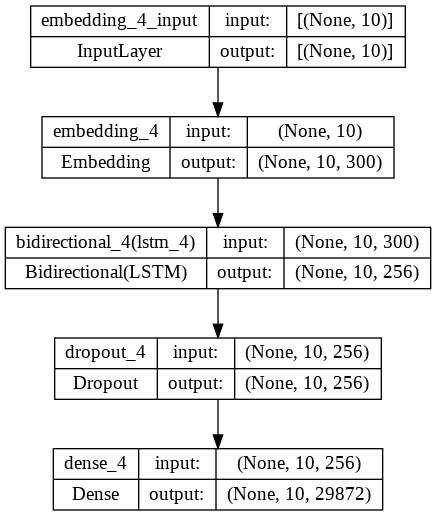

In [ ]:
bidirectional_LSTM_Glove_de_en = Sequential()
embedding_layer = Embedding(input_dim = ger_VocabSize+1,output_dim = glove_dim, input_length = word_reduction_limit, weights = [ger_glove_data])
bidirectional_LSTM_Glove_de_en.add(embedding_layer)
bidirectional_LSTM_Glove_de_en.add(Bidirectional(LSTM(units=128,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),return_sequences=True )))
bidirectional_LSTM_Glove_de_en.add(Dropout(0.3))
bidirectional_LSTM_Glove_de_en.add(Dense(eng_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.01)
bidirectional_LSTM_Glove_de_en.compile(optimizer=rms, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
bidirectional_LSTM_Glove_de_en.summary()
bidirectional_LSTM_de_en_Glove_pic = "/content/drive/MyDrive/Learning/bidirect_model_de_en.png"
plot_model(bidirectional_LSTM_Glove_de_en, to_file= bidirectional_LSTM_de_en_Glove_pic, show_shapes=True, show_layer_names=True)

In [ ]:
bd_lstm_GloVe_de_en_name = 'bidirectional_LSTM_GloVe_de_en'
batch_size = 256
epoch_val = 30
bd_lstm_GloVe_de_en_history = train_and_fit_model(bidirectional_LSTM_Glove_de_en, epoch_val, batch_size, Y_train_proc, X_train_proc, Y_val_proc, X_val_proc, bd_lstm_GloVe_de_en_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.37939, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 51s - loss: 6.3476 - accuracy: 0.3298 - val_loss: 5.8736 - val_accuracy: 0.3794 - 51s/epoch - 203ms/step
Epoch 2/30

Epoch 2: val_accuracy improved from 0.37939 to 0.40324, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 39s - loss: 5.3442 - accuracy: 0.3749 - val_loss: 4.9397 - val_accuracy: 0.4032 - 39s/epoch - 155ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.40324 to 0.41047, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 39s - loss: 5.1159 - accuracy: 0.3887 - val_loss: 4.9423 - val_accuracy: 0.4105 - 39s/epoch - 154ms/step
Epoch 4/30

Epoch 4: val_accuracy did not improve from 0.41047
250/250 - 27s - loss: 4.9651 - accuracy: 0.3966 - val_loss: 4.7363 - val_accuracy: 0.4057 - 27s/epoch - 108ms/step
Epoch 5/30

Epoch 5: val_accuracy improved from 0.41047 to 0.41399, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 41s - loss: 4.8503 - accuracy: 0.4032 - val_loss: 4.6996 - val_accuracy: 0.4140 - 41s/epoch - 162ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.41399
250/250 - 27s - loss: 4.7719 - accuracy: 0.4077 - val_loss: 4.7061 - val_accuracy: 0.4107 - 27s/epoch - 106ms/step
Epoch 7/30

Epoch 7: val_accuracy improved from 0.41399 to 0.41891, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 39s - loss: 4.7403 - accuracy: 0.4116 - val_loss: 4.6834 - val_accuracy: 0.4189 - 39s/epoch - 157ms/step
Epoch 8/30

Epoch 8: val_accuracy did not improve from 0.41891
250/250 - 27s - loss: 4.7165 - accuracy: 0.4152 - val_loss: 4.6834 - val_accuracy: 0.4143 - 27s/epoch - 106ms/step
Epoch 9/30

Epoch 9: val_accuracy improved from 0.41891 to 0.42001, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 40s - loss: 4.6845 - accuracy: 0.4187 - val_loss: 4.6748 - val_accuracy: 0.4200 - 40s/epoch - 162ms/step
Epoch 10/30

Epoch 10: val_accuracy improved from 0.42001 to 0.42054, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 39s - loss: 4.6530 - accuracy: 0.4220 - val_loss: 4.6581 - val_accuracy: 0.4205 - 39s/epoch - 155ms/step
Epoch 11/30

Epoch 11: val_accuracy did not improve from 0.42054
250/250 - 27s - loss: 4.6261 - accuracy: 0.4246 - val_loss: 4.7051 - val_accuracy: 0.4177 - 27s/epoch - 108ms/step
Epoch 12/30

Epoch 12: val_accuracy improved from 0.42054 to 0.42504, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 41s - loss: 4.6050 - accuracy: 0.4269 - val_loss: 4.7503 - val_accuracy: 0.4250 - 41s/epoch - 165ms/step
Epoch 13/30

Epoch 13: val_accuracy did not improve from 0.42504
250/250 - 27s - loss: 4.5856 - accuracy: 0.4283 - val_loss: 4.7222 - val_accuracy: 0.4250 - 27s/epoch - 106ms/step
Epoch 14/30

Epoch 14: val_accuracy did not improve from 0.42504
250/250 - 27s - loss: 4.5662 - accuracy: 0.4304 - val_loss: 4.6975 - val_accuracy: 0.4245 - 27s/epoch - 109ms/step
Epoch 15/30

Epoch 15: val_accuracy improved from 0.42504 to 0.42876, saving model to bidirectional_LSTM_GloVe_de_en


250/250 - 39s - loss: 4.5488 - accuracy: 0.4324 - val_loss: 4.7179 - val_accuracy: 0.4288 - 39s/epoch - 155ms/step


Printing accuracy details for bidirectional_LSTM_GloVe_de_en
Test Accuracy: 42.38%
Validation Accuracy: 42.05%
Train Accuracy: 43.24%


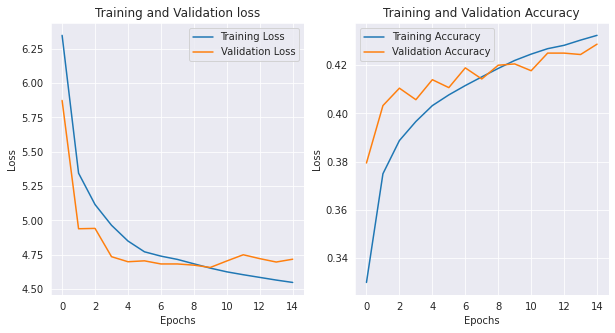

In [ ]:
trained_bd_lstm_GloVe_de_en = print_and_store_accuracy(bd_lstm_GloVe_de_en_name,Y_train_proc,Y_val_proc,Y_test_proc,X_train_proc,X_val_proc,X_test_proc)
plot_results(bd_lstm_GloVe_de_en_history)

In [ ]:
bd_lstm_GloVe_predicted_de_en_df,df_summary = predict_and_print_top_20(trained_bd_lstm_GloVe_de_en,Y_test_proc, Y_test, X_test, eng_Tokenizer)
bd_lstm_GloVe_predicted_de_en_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy  \
0                simple_RNN_en_de        24.72%              24.96%   
1               simple_LSTM_en_de        43.25%              43.18%   
2               simple_LSTM_de_en        40.12%              40.07%   
3           lstm_with_GloVe_en_de        44.58%              44.38%   
4           LSTM_with_GloVe_de_en        42.33%              42.10%   
5        bidirectional_LSTM_de_en        42.72%              42.32%   
6        bidirectional_LSTM_en_de        42.96%              42.67%   
7  bidirectional_LSTM_GloVe_de_en        42.38%              42.05%   

  Train Accuracy SacreBleu METEOR - Average METEOR - Max  
0         34.70%      5.57             0.35         0.68  
1         40.72%      3.86             0.31         0.52  
2         45.58%      6.78             0.29         0.69  
3         42.68%      7.69             0.28         0.72  
4         42.97%      3.55              0.3         0.57  
5         43.47%      6.39             0.45         0.89  
6         39.56%      5.27             0.27         0.71  
7         43.24%      5.96             0.46         0.89

#### Bidirectional LSTM with Glove (German to English) - Observation

1.   With introduction of Bi-directional LSTM and GloVe together, we couldn't see significant improvement in accuracy while comparing to Bi-directional LSTM model without embeddings.
2.   However the model was able to predict one of the sentence with 89%.
3.   Encoder/Decoder options to be explored if we can get better predictions.




#### Bidirectional LSTM (English to German)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 10, 300)           8961600   
                                                                 
 bidirectional_5 (Bidirectio  (None, 10, 1024)         3330048   
 nal)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 10, 1024)          0         
                                                                 
 dense_5 (Dense)             (None, 10, 50693)         51960325  
                                                                 
Total params: 64,251,973
Trainable params: 64,251,973
Non-trainable params: 0
_________________________________________________________________


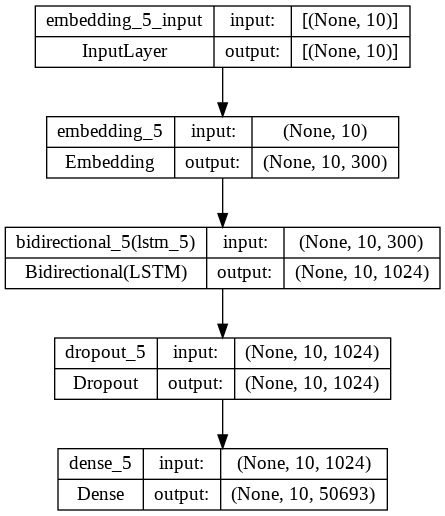

In [ ]:
bd_LSTM_GloVe_en_de = Sequential()
embedding_layer = Embedding(input_dim = eng_VocabSize+1,output_dim = glove_dim, input_length = word_reduction_limit, weights = [eng_glove_data])
bd_LSTM_GloVe_en_de.add(embedding_layer)
bd_LSTM_GloVe_en_de.add(Bidirectional(LSTM(units=512,kernel_regularizer=l2(0.01), recurrent_regularizer=l2(0.01), bias_regularizer=l2(0.01),return_sequences=True )))
bd_LSTM_GloVe_en_de.add(Dropout(0.3))
bd_LSTM_GloVe_en_de.add(Dense(ger_VocabSize+1, activation='softmax'))
rms = optimizers.RMSprop(learning_rate=0.01)
bd_LSTM_GloVe_en_de.compile(optimizer=rms, loss= 'sparse_categorical_crossentropy', metrics=['accuracy'])
bd_LSTM_GloVe_en_de.summary()
bd_LSTM_GloVe_en_de_pic = "/content/drive/MyDrive/Learning/bidirect_model_GloVe_en_de.png"
plot_model(bd_LSTM_GloVe_en_de, to_file= bd_LSTM_GloVe_en_de_pic, show_shapes=True, show_layer_names=True)

In [ ]:
bd_lstm_GloVe_en_de_name = 'bidirectional_LSTM_GloVe_en_de'
batch_size = 256
epoch_val = 30
bd_lstm_GloVe_en_de_history = train_and_fit_model(bd_LSTM_GloVe_en_de, epoch_val, batch_size, X_train_proc, Y_train_proc, X_val_proc, Y_val_proc, bd_lstm_GloVe_en_de_name)

Epoch 1/30

Epoch 1: val_accuracy improved from -inf to 0.40129, saving model to bidirectional_LSTM_GloVe_en_de


250/250 - 118s - loss: 8.8178 - accuracy: 0.3358 - val_loss: 5.6986 - val_accuracy: 0.4013 - 118s/epoch - 472ms/step
Epoch 2/30

Epoch 2: val_accuracy did not improve from 0.40129
250/250 - 101s - loss: 6.5871 - accuracy: 0.3684 - val_loss: 5.8354 - val_accuracy: 0.3922 - 101s/epoch - 404ms/step
Epoch 3/30

Epoch 3: val_accuracy improved from 0.40129 to 0.42080, saving model to bidirectional_LSTM_GloVe_en_de


250/250 - 115s - loss: 6.3869 - accuracy: 0.3780 - val_loss: 5.5096 - val_accuracy: 0.4208 - 115s/epoch - 460ms/step
Epoch 4/30

Epoch 4: val_accuracy improved from 0.42080 to 0.42315, saving model to bidirectional_LSTM_GloVe_en_de


250/250 - 114s - loss: 6.2570 - accuracy: 0.3836 - val_loss: 5.6772 - val_accuracy: 0.4232 - 114s/epoch - 458ms/step
Epoch 5/30

Epoch 5: val_accuracy did not improve from 0.42315
250/250 - 101s - loss: 6.1002 - accuracy: 0.3892 - val_loss: 5.5769 - val_accuracy: 0.4167 - 101s/epoch - 404ms/step
Epoch 6/30

Epoch 6: val_accuracy did not improve from 0.42315
250/250 - 101s - loss: 6.0247 - accuracy: 0.3919 - val_loss: 5.7125 - val_accuracy: 0.4158 - 101s/epoch - 403ms/step
Epoch 7/30

Epoch 7: val_accuracy did not improve from 0.42315
250/250 - 100s - loss: 6.0356 - accuracy: 0.3946 - val_loss: 5.6160 - val_accuracy: 0.4190 - 100s/epoch - 402ms/step
Epoch 8/30

Epoch 8: val_accuracy improved from 0.42315 to 0.43279, saving model to bidirectional_LSTM_GloVe_en_de


250/250 - 116s - loss: 6.0311 - accuracy: 0.3964 - val_loss: 5.5709 - val_accuracy: 0.4328 - 116s/epoch - 462ms/step


Printing accuracy details for bidirectional_LSTM_GloVe_en_de
Test Accuracy: 42.43%
Validation Accuracy: 42.08%
Train Accuracy: 39.46%


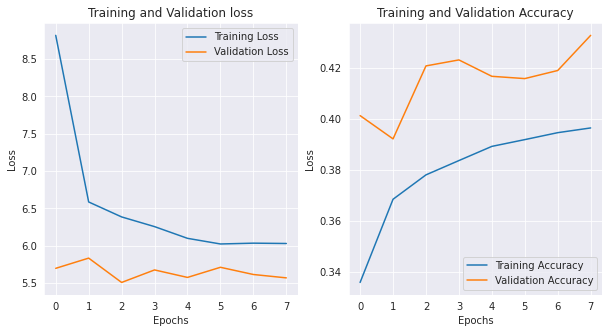

In [ ]:
trained_bd_lstm_GloVe_en_de = print_and_store_accuracy(bd_lstm_GloVe_en_de_name,X_train_proc,X_val_proc,X_test_proc,Y_train_proc,Y_val_proc,Y_test_proc)
plot_results(bd_lstm_GloVe_en_de_history)

In [ ]:
bd_lstm_GloVe_predicted_en_de_df,df_summary = predict_and_print_top_20(trained_bd_lstm_GloVe_en_de,X_test_proc, X_test, Y_test, ger_Tokenizer)
bd_lstm_GloVe_predicted_en_de_df.style.apply(highlight_pred)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy  \
0                simple_RNN_en_de        24.72%              24.96%   
1               simple_LSTM_en_de        43.25%              43.18%   
2               simple_LSTM_de_en        40.12%              40.07%   
3           lstm_with_GloVe_en_de        44.58%              44.38%   
4           LSTM_with_GloVe_de_en        42.33%              42.10%   
5        bidirectional_LSTM_de_en        42.72%              42.32%   
6        bidirectional_LSTM_en_de        42.96%              42.67%   
7  bidirectional_LSTM_GloVe_de_en        42.38%              42.05%   
8  bidirectional_LSTM_GloVe_en_de        42.43%              42.08%   

  Train Accuracy SacreBleu METEOR - Average METEOR - Max  
0         34.70%      5.57             0.35         0.68  
1         40.72%      3.86             0.31         0.52  
2         45.58%      6.78             0.29         0.69  
3         42.68%      7.69             0.28         0.72  
4         42.97%      3.55              0.3         0.57  
5         43.47%      6.39             0.45         0.89  
6         39.56%      5.27             0.27         0.71  
7         43.24%      5.96             0.46         0.89  
8         39.46%      7.69             0.33         0.77

In [ ]:
#Storing summary until milestone 2 in pickle file
summary_until_milestone2 = "/content/drive/MyDrive/Learning/summary_until_milestone2.pkl"
#function to save pickle file
def saveas_pickle_file(df, filename):
    df.to_pickle(filename)
    print('Saved: %s' % filename)
saveas_pickle_file(df_summary, summary_until_milestone2) 

Saved: /content/drive/MyDrive/Learning/summary_until_milestone2.pkl


#### Bidirectional LSTM with Glove (English to German) - Observation


1.   With introduction of Bi-directional LSTM and GloVe together, we couldn't see significant improvement in accuracy while comparing to Bi-directional LSTM model without embeddings.
2.   However the model was able to predict one of the sentence with 77% (best among models with same language pairs so far).
3.   Encoder/Decoder options to be explored if we can get better predictions.




####Encoder-Decoder RNN & LSTM model

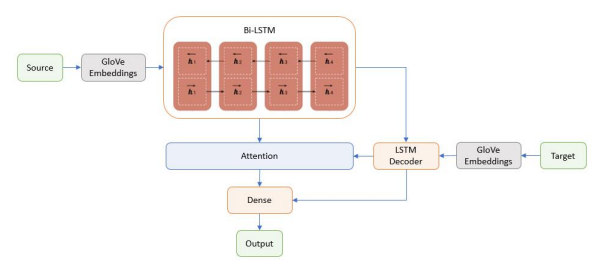

In [ ]:
Encoder_decoder_with_attention_Diagram = Image.open(r"/content/drive/MyDrive/Learning/Encoder_Decoder_with_ attention_diagram.png")
Encoder_decoder_with_attention_Diagram

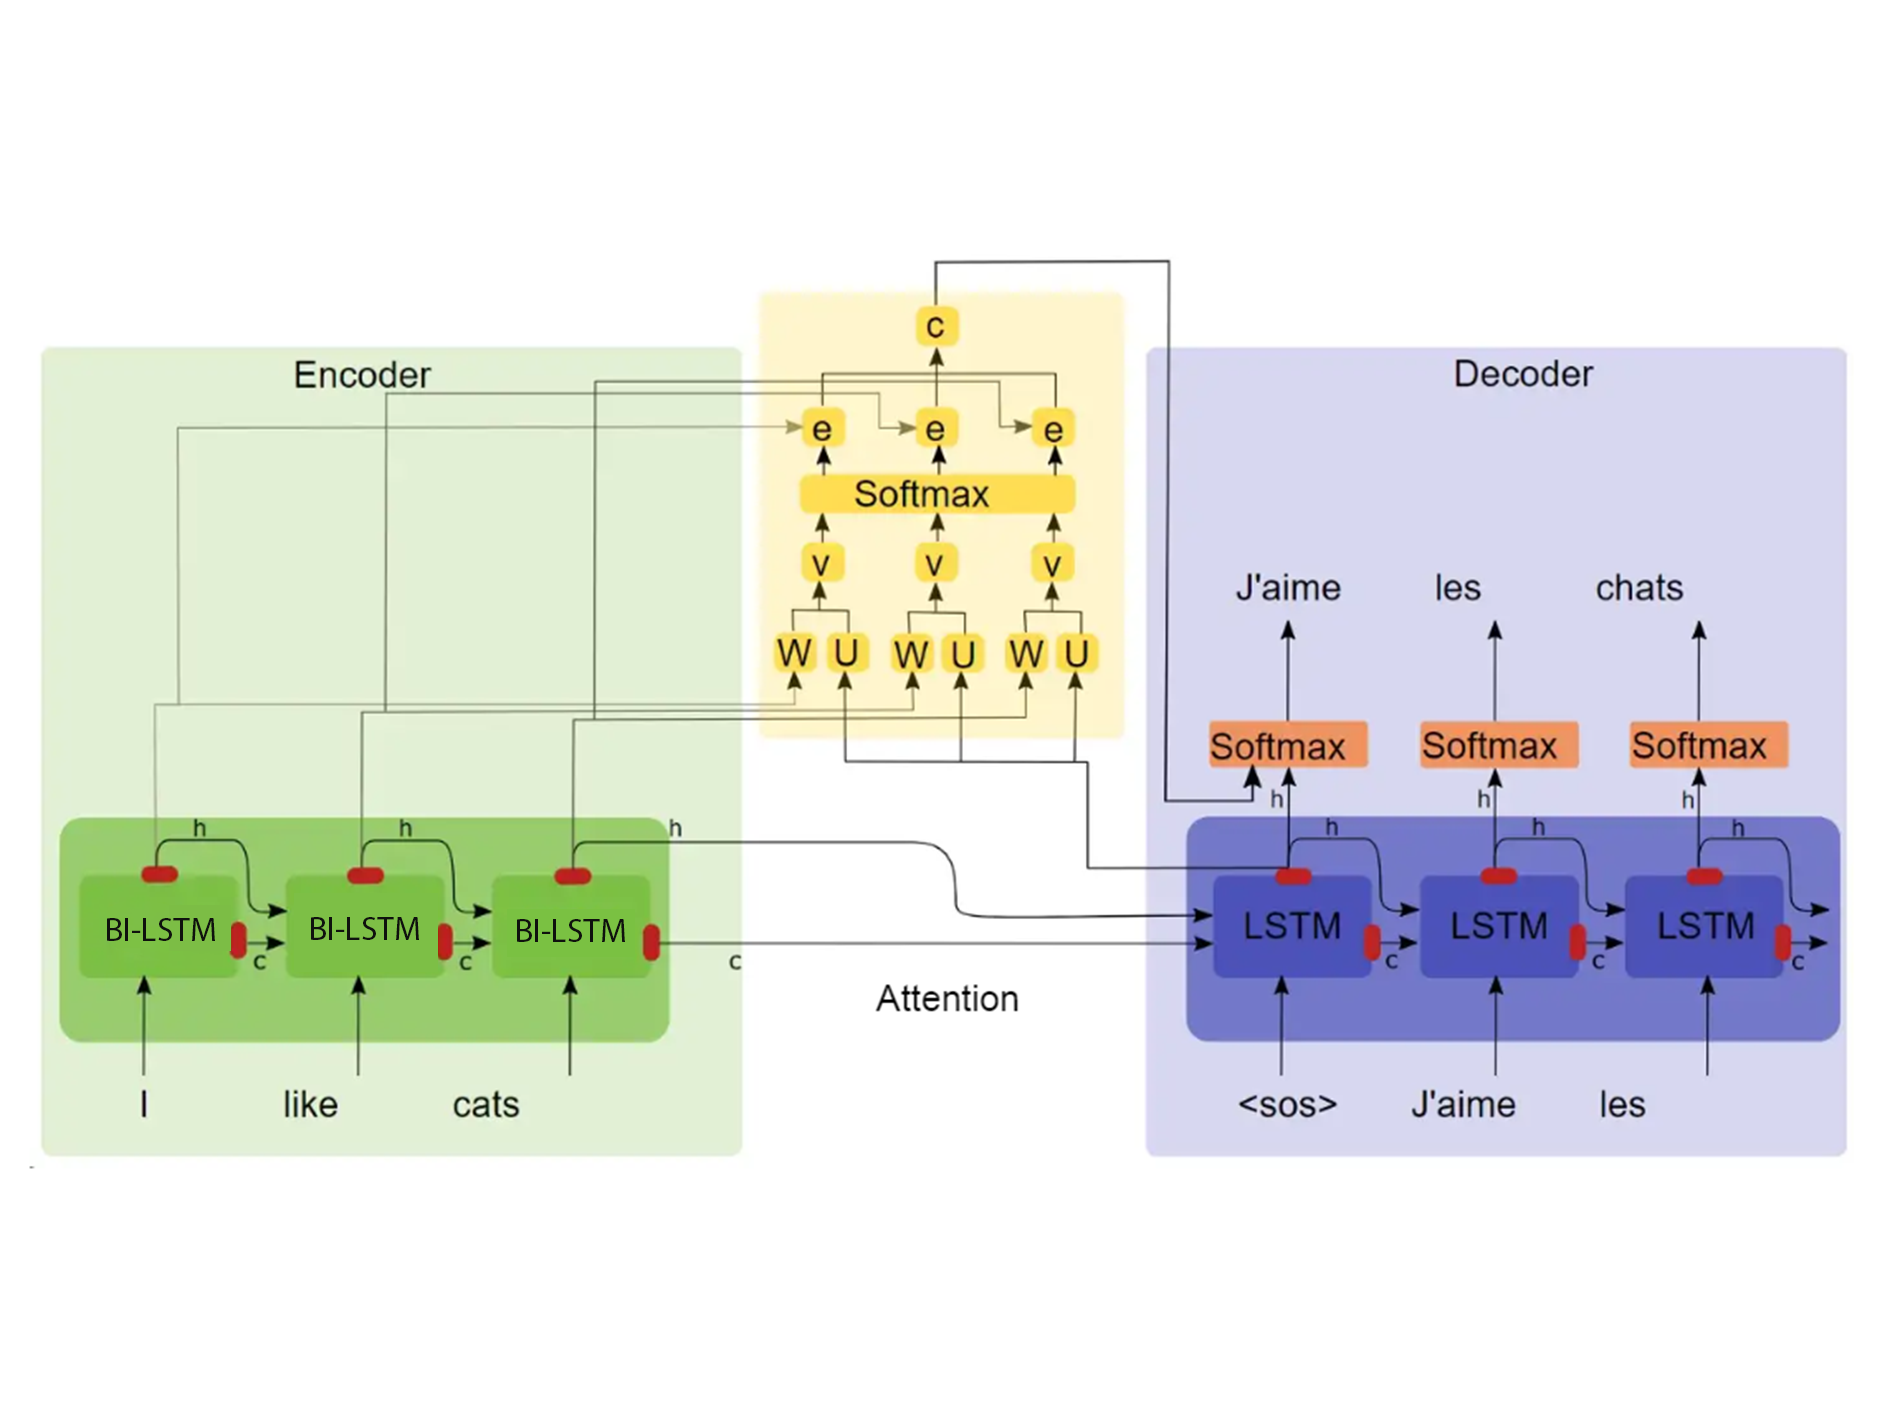

In [ ]:
Encoder_decoder_Functioning_Diagram = Image.open(r"/content/drive/MyDrive/Learning/Encoder_Decoder_functioning_diagram.png")
Encoder_decoder_Functioning_Diagram

#### Encoder Decoder LSTM (German to English)

In [ ]:
sample_size = 100000
X_train,X_test,Y_train,Y_test,X_val,Y_val = split_input_target(sample_size,'encoder_decoder')
X_train_proc,X_test_proc,X_val_proc,eng_MaxLength,eng_VocabSize,eng_WordIndex,eng_Tokenizer,eng_TokenizedStrings = tokenize_seq_pad(X_train, X_test, X_val, word_reduction_limit, 'en')
Y_train_proc,Y_test_proc,Y_val_proc,ger_MaxLength,ger_VocabSize,ger_WordIndex,ger_Tokenizer,ger_TokenizedStrings = tokenize_seq_pad(Y_train, Y_test, Y_val, word_reduction_limit, 'de')
#Reshaping the vaues to get three dimensional shapes
X_tr_reshaped = X_train_proc.reshape(X_train_proc.shape[0],X_train_proc.shape[1],1)
X_te_reshaped = X_test_proc.reshape(X_test_proc.shape[0], X_test_proc.shape[1],1)
X_va_reshaped = X_val_proc.reshape(X_val_proc.shape[0], X_val_proc.shape[1],1)
Y_tr_reshaped = Y_train_proc.reshape(Y_train_proc.shape[0],Y_train_proc.shape[1],1)
Y_te_reshaped = Y_test_proc.reshape(Y_test_proc.shape[0], Y_test_proc.shape[1],1)
Y_va_reshaped = Y_val_proc.reshape(Y_val_proc.shape[0], Y_val_proc.shape[1],1)

Shape of X_train is : (64000,)
Shape of X_test is : (20000,)
Shape of X_validation is : (16000,)
Shape of Y_train is : (64000,)
Shape of Y_test is : (20000,)
Shape of Y_validation is : (16000,)
----------------------------------------------------------------------------------------------------
Printing Details for English language:
Below are the details after performing tokenization, sequencing and padding:
Max token length : 10
Vocab Count : 29873
Longest word : kommunikationswissenschaftler
Length of longest word : 29
Printing random sentence and corresponding padded tokens:
Below is the original sentence:
sos silverfast simulates the traditional proof and its combinations eos
Below is the padded tokens for the above sentence
[    1  6195 10469     3  1276  1708    10    75  5048     2]
----------------------------------------------------------------------------------------------------
---------------------------------------------------------------------------------------------------

### Defining a custom Attention layer

In [ ]:
from tensorflow.python.keras import backend as K

logger = tf.get_logger()

class AttentionLayer(tf.keras.layers.Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs

        logger.debug(f"encoder_out_seq.shape = {encoder_out_seq.shape}")
        logger.debug(f"decoder_out_seq.shape = {decoder_out_seq.shape}")

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state
            inputs: (batchsize * 1 * de_in_dim)
            states: (batchsize * 1 * de_latent_dim)
            """
            logger.debug("Running energy computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch size * en_seq_len * latent_dim
            W_a_dot_s = K.dot(encoder_full_seq, self.W_a)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim

            logger.debug(f"U_a_dot_h.shape = {U_a_dot_h.shape}")

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            Ws_plus_Uh = K.tanh(W_a_dot_s + U_a_dot_h)

            logger.debug(f"Ws_plus_Uh.shape = {Ws_plus_Uh.shape}")

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.squeeze(K.dot(Ws_plus_Uh, self.V_a), axis=-1)
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            logger.debug(f"ei.shape = {e_i.shape}")

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """

            logger.debug("Running attention vector computation step")

            if not isinstance(states, (list, tuple)):
                raise TypeError(f"States must be an iterable. Got {states} of type {type(states)}")

            encoder_full_seq = states[-1]

            # <= batch_size, hidden_size
            c_i = K.sum(encoder_full_seq * K.expand_dims(inputs, -1), axis=1)

            logger.debug(f"ci.shape = {c_i.shape}")

            return c_i, [c_i]

        # we don't maintain states between steps when computing attention
        # attention is stateless, so we're passing a fake state for RNN step function
        fake_state_c = K.sum(encoder_out_seq, axis=1)
        fake_state_e = K.sum(encoder_out_seq, axis=2)  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e], constants=[encoder_out_seq]
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c], constants=[encoder_out_seq]
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]

### Encode-Decoder with Attention

#### Encoder

In [ ]:
# Encoder input
encoder_inputs = Input(shape=(eng_MaxLength,)) 

# Embedding layer- using output-dim same as glove dimension
enc_emb = Embedding(eng_VocabSize+1, glove_dim, weights = [eng_glove_data], trainable=False)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c 
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

#### Decoder

In [ ]:
#  decoder input
decoder_inputs = Input(shape=(None,)) 

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(ger_VocabSize+1, glove_dim, weights = [ger_glove_data], trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction 

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1,decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(ger_VocabSize, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

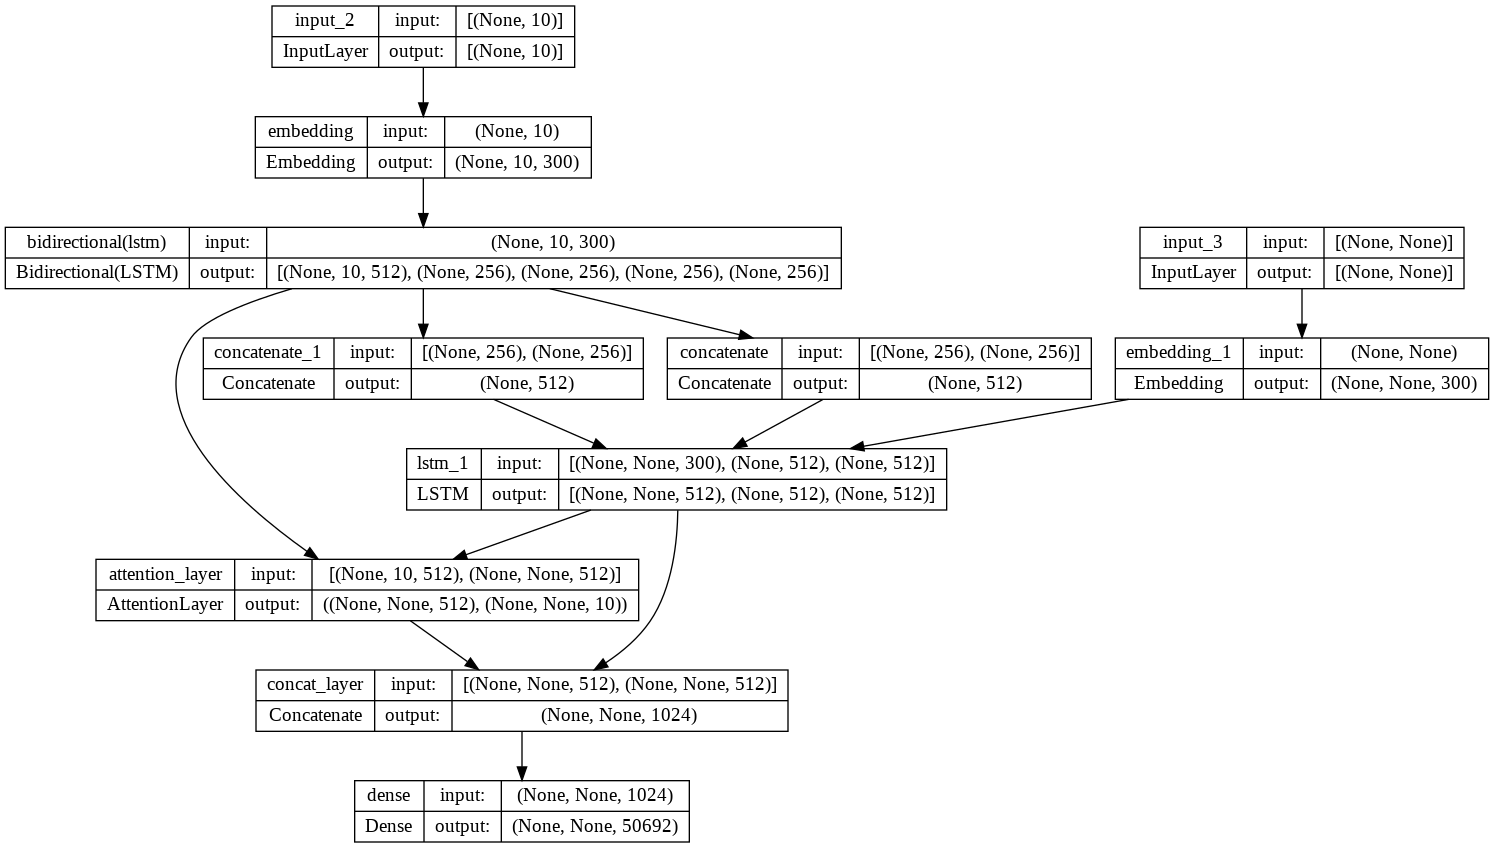

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

### Train the Attention model

In [ ]:
checkpoint_filename = '/content/drive/MyDrive/Learning/enc_dec_checkpoint.h5'
model_weights_filename = '/content/drive/MyDrive/Learning/enc_dec_model.h5'
# compile model
#rms = optimizers.RMSprop(learning_rate=0.01)
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(checkpoint_filename, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_train = X_train_proc
# To make same as target data skip last number which is just padding
decoder_input_train = Y_train_proc[:,:-1]
# Decoder target data has to be one step ahead so we are taking from 1 as told in keras docs
decoder_target_train =  Y_train_proc[:,1:]


# validation set
encoder_input_val = X_val_proc
decoder_input_val = Y_val_proc[:,:-1]
decoder_target_val=  Y_val_proc[:,1:]

# test set
encoder_input_test = X_test_proc
decoder_input_test = Y_test_proc[:,:-1]
decoder_target_test=  Y_test_proc[:,1:]

EPOCHS = 30
BATCH_SIZE = 512
history = model.fit([encoder_input_train, decoder_input_train],decoder_target_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data = ([encoder_input_val, decoder_input_val],decoder_target_val),
                    callbacks= callbacks_list)
# save weights of trained model 
model.save_weights(model_weights_filename)

Epoch 1/30
125/125 [==============================] - 106s 782ms/step - loss: 5.8914 - accuracy: 0.2796 - val_loss: 4.6980 - val_accuracy: 0.3715
Epoch 2/30
125/125 [==============================] - 91s 731ms/step - loss: 4.7765 - accuracy: 0.3587 - val_loss: 4.0559 - val_accuracy: 0.4152
Epoch 3/30
125/125 [==============================] - 92s 737ms/step - loss: 4.1706 - accuracy: 0.3996 - val_loss: 3.7602 - val_accuracy: 0.4416
Epoch 4/30
125/125 [==============================] - 91s 732ms/step - loss: 3.7302 - accuracy: 0.4302 - val_loss: 3.5841 - val_accuracy: 0.4569
Epoch 5/30
125/125 [==============================] - 91s 728ms/step - loss: 3.3710 - accuracy: 0.4577 - val_loss: 3.4796 - val_accuracy: 0.4676
Epoch 6/30
125/125 [==============================] - 91s 728ms/step - loss: 3.0689 - accuracy: 0.4824 - val_loss: 3.4396 - val_accuracy: 0.4719
Epoch 7/30
125/125 [==============================] - 91s 728ms/step - loss: 2.8021 - accuracy: 0.5080 - val_loss: 3.3806 - val_a

### Inference Model

In [ ]:
pickle.dump(model, open(checkpoint_filename, 'wb'))
model_to_load = pickle.load(open(checkpoint_filename, 'rb'))

# Its good to restart runtime and create model and load weights
model_to_load.load_weights(model_weights_filename)

# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
# It has to be same as input taken by attention layer
decoder_hidden_state_input = Input(shape=(word_reduction_limit,512)) 
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer 
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model(
                     [decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Prediction

In [ ]:
def get_predicted_sentence(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = ger_WordIndex['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    sampled_char = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ], verbose=0)

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= word_reduction_limit):
          stop_condition = True
        else:
          # Sample a token
          sampled_token_index = np.argmax(output_tokens[0, -1, :],axis=-1)
          # convert max index number to german word
          sampled_char = list(ger_WordIndex.keys())[sampled_token_index-1]
          # append it to decoded sent
          decoded_sentence += ' '+sampled_char
          
          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index
          # Update states
          enc_h, enc_c = h, c

    translated_sentence = decoded_sentence.replace(list(ger_WordIndex.keys())[ger_VocabSize-2],'').strip()
    
    return translated_sentence

### Results

In [ ]:
# function to convert tokens back to words

# function to convert tokens back to english words
def get_english_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i>0:
        sentence = sentence + list(eng_WordIndex.keys())[i-1]+' '
    return sentence   

# function to convert tokens back to german words
def get_german_sentence(input_sequence):
    sentence =''
    for i in input_sequence:
      if i>0 :
        sentence = sentence + list(ger_WordIndex.keys())[i-1]+' '
    return sentence

df_predict_encoder_decoder = pd.DataFrame(columns=['random_index','input','actual','predicted','METEOR'])

# using simple loop we will take random numbers from X_test_proc and get results
for i in np.random.randint(10, 1000, size=20):
  Input_value = get_english_sentence(X_test_proc[i])[4:-5]
  Actual_value = get_german_sentence(Y_test_proc[i])[4:-5]
  pred = get_predicted_sentence(X_test_proc[i].reshape(1, word_reduction_limit))
  Predicted_value = pred[:-4]
  df_predict_encoder_decoder.loc[len(df_predict_encoder_decoder.index)] = [i,Input_value,Actual_value,Predicted_value,'']

actual = df_predict_encoder_decoder['actual']
predicted = df_predict_encoder_decoder['predicted']
df_predict_encoder_decoder['METEOR'] = meteor_calc(actual,predicted)

df_predict_encoder_decoder.style.apply(highlight_pred)
#df_predict_encoder_decoder.style.format('{:.2f}').highlight_max(color = 'green', subset=['METEOR']).highlight_min(color = 'red', subset = ['METEOR'])

### Performance Results

Printing accuracy details for encoder_decoder_en_de
Test Accuracy: 47.52%
Validation Accuracy: 47.01%
Train Accuracy: 76.13%


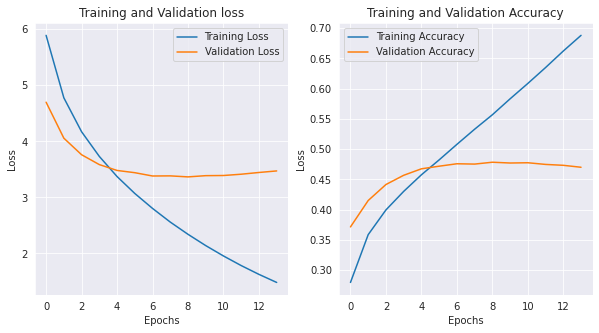

In [ ]:
model_name = 'encoder_decoder_en_de'
source_train = [encoder_input_train, decoder_input_train]
source_val = [encoder_input_val, decoder_input_val]
source_test = [encoder_input_test, decoder_input_test]
test_acc = model.evaluate(source_test, decoder_target_test, verbose=0)
val_acc = model.evaluate(source_val, decoder_target_val, verbose=0)
train_acc = model.evaluate(source_train, decoder_target_train, verbose=0)
test_accuracy = '{:.2%}'.format(test_acc[1])
val_accuracy = '{:.2%}'.format(val_acc[1])
train_accuracy = '{:.2%}'.format(train_acc[1])
print('Printing accuracy details for',model_name)
print('Test Accuracy:',test_accuracy)
print('Validation Accuracy:',val_accuracy)
print('Train Accuracy:',train_accuracy)
sacreblue_acc = corpus_accuracy(df_predict_encoder_decoder)
sacrebleu_score = round(sacreblue_acc,2)
meteor_avg = round(df_predict_encoder_decoder['METEOR'].mean(),2)
meteor_max = round(df_predict_encoder_decoder['METEOR'].max(),2)
df_summary.loc[len(df_summary.index)] = [model_name,test_accuracy,val_accuracy,train_accuracy,sacrebleu_score,meteor_avg,meteor_max]
plot_results(history)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy  \
0                simple_RNN_en_de        24.72%              24.96%   
1               simple_LSTM_en_de        43.25%              43.18%   
2               simple_LSTM_de_en        40.12%              40.07%   
3           lstm_with_GloVe_en_de        44.58%              44.38%   
4           LSTM_with_GloVe_de_en        42.33%              42.10%   
5        bidirectional_LSTM_de_en        42.72%              42.32%   
6        bidirectional_LSTM_en_de        42.96%              42.67%   
7  bidirectional_LSTM_GloVe_de_en        42.38%              42.05%   
8  bidirectional_LSTM_GloVe_en_de        42.43%              42.08%   
9           encoder_decoder_en_de        47.52%              47.01%   

  Train Accuracy SacreBleu METEOR - Average METEOR - Max  
0         34.70%      5.57             0.35         0.68  
1         40.72%      3.86             0.31         0.52  
2         45.58%      6.78             0.29         0.69  
3         42.68%      7.69             0.28         0.72  
4         42.97%      3.55              0.3         0.57  
5         43.47%      6.39             0.45         0.89  
6         39.56%      5.27             0.27         0.71  
7         43.24%      5.96             0.46         0.89  
8         39.46%      7.69             0.33         0.77  
9         76.13%     17.01             0.37          1.0

In [ ]:
#Storing summary until milestone 2 in pickle file
summary_until_milestone2 = "/content/drive/MyDrive/Learning/summary_until_milestone2.pkl"
#function to save pickle file
def saveas_pickle_file(df, filename):
    df.to_pickle(filename)
    print('Saved: %s' % filename)
saveas_pickle_file(df_summary, summary_until_milestone2) 

Saved: /content/drive/MyDrive/Learning/summary_until_milestone2.pkl


#### Encoder Decoder LSTM with Attention (English to German) - Observation


1.   Significant improvement has been observed in accuracy for Encoder/Decoder model with Attention mechanism
2.   Model was able to predict one of the 10 samples flawlessly with meteor score of 100%
3.   Train accuracy has reached more than 76% which indicates model has trained 40% better than previous models
4.   Larger dataset and even complex models (with required computations capabilities) can be explored for better predictions.



#### Encoder Decoder LSTM (German to English)

### Encoder

In [ ]:
# Encoder input
encoder_inputs = Input(shape=(ger_MaxLength,)) 

# Embedding layer- using output-dim same as glove embedding (300)
enc_emb = Embedding(ger_VocabSize+1, glove_dim, weights = [ger_glove_data], trainable=False)(encoder_inputs)

# Bidirectional lstm layer
enc_lstm1 = Bidirectional(LSTM(256,return_sequences=True,return_state=True))
encoder_outputs1, forw_state_h, forw_state_c, back_state_h, back_state_c = enc_lstm1(enc_emb)

# Concatenate both h and c 
final_enc_h = Concatenate()([forw_state_h,back_state_h])
final_enc_c = Concatenate()([forw_state_c,back_state_c])

# get Context vector
encoder_states =[final_enc_h, final_enc_c]

### Decoder

In [ ]:
#  decoder input
decoder_inputs = Input(shape=(None,)) 

# decoder embedding with same number as encoder embedding
dec_emb_layer = Embedding(eng_VocabSize+1, glove_dim, weights = [eng_glove_data], trainable=False) 
dec_emb = dec_emb_layer(decoder_inputs)   # apply this way because we need embedding layer for prediction 

# In encoder we used Bidirectional so it's having two LSTM's so we have to take double units(256*2=512) for single decoder lstm
# LSTM using encoder's final states as initial state
decoder_lstm = LSTM(512, return_sequences=True, return_state=True) 
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)

# Using Attention Layer
attention_layer = AttentionLayer()
attention_result, attention_weights = attention_layer([encoder_outputs1,decoder_outputs])

# Concat attention output and decoder LSTM output 
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attention_result])

# Dense layer with softmax
decoder_dense = Dense(eng_VocabSize, activation='softmax')
decoder_outputs = decoder_dense(decoder_concat_input)


# Define the model
model_de_en = Model([encoder_inputs, decoder_inputs], decoder_outputs) 

### Train the Attention Model

In [ ]:
checkpoint_filename_de_en = '/content/drive/MyDrive/Learning/enc_dec_checkpoint_de_en.h5'
model_weights_filename_de_en = '/content/drive/MyDrive/Learning/enc_dec_model_de_en.h5'

# compile model
model_de_en.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
checkpoint = ModelCheckpoint(checkpoint_filename_de_en, monitor='val_accuracy')
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5)
callbacks_list = [checkpoint, early_stopping]

# Training set
encoder_input_train = Y_train_proc
decoder_input_train = X_train_proc[:,:-1]
decoder_target_train =  X_train_proc[:,1:]

# development set
encoder_input_val = Y_val_proc
decoder_input_val = X_val_proc[:,:-1]
decoder_target_val =  X_val_proc[:,1:]


# development set
encoder_input_test = Y_test_proc
decoder_input_test = X_test_proc[:,:-1]
decoder_target_test =  X_test_proc[:,1:]

EPOCHS = 30
BATCH_SIZE = 512
history = model_de_en.fit([encoder_input_train, decoder_input_train],decoder_target_train, 
                    epochs=EPOCHS, 
                    batch_size=BATCH_SIZE,
                    validation_data = ([encoder_input_val, decoder_input_val],decoder_target_val),
                    callbacks= callbacks_list)

# save weights of trained model 
model_de_en.save_weights(model_weights_filename_de_en)

Epoch 1/30
125/125 [==============================] - 67s 495ms/step - loss: 5.5910 - accuracy: 0.2830 - val_loss: 4.6583 - val_accuracy: 0.3620
Epoch 2/30
125/125 [==============================] - 59s 472ms/step - loss: 4.6314 - accuracy: 0.3736 - val_loss: 4.2119 - val_accuracy: 0.4091
Epoch 3/30
125/125 [==============================] - 60s 477ms/step - loss: 4.1614 - accuracy: 0.4099 - val_loss: 3.9924 - val_accuracy: 0.4302
Epoch 4/30
125/125 [==============================] - 60s 477ms/step - loss: 3.8234 - accuracy: 0.4334 - val_loss: 3.9039 - val_accuracy: 0.4389
Epoch 5/30
125/125 [==============================] - 60s 479ms/step - loss: 3.5497 - accuracy: 0.4520 - val_loss: 3.8047 - val_accuracy: 0.4527
Epoch 6/30
125/125 [==============================] - 60s 476ms/step - loss: 3.3101 - accuracy: 0.4685 - val_loss: 3.7093 - val_accuracy: 0.4627
Epoch 7/30
125/125 [==============================] - 59s 475ms/step - loss: 3.0929 - accuracy: 0.4849 - val_loss: 3.6851 - val_ac

### Inference Model

In [ ]:
pickle.dump(model_de_en, open(checkpoint_filename_de_en, 'wb'))
model_to_load_de_en = pickle.load(open(checkpoint_filename_de_en, 'rb'))

# Its good to restart runtime and create model and load weights
model_de_en.load_weights(model_weights_filename_de_en)

# INFERENCE MODEL
# encoder Inference model
encoder_model = Model(encoder_inputs, outputs = [encoder_outputs1, final_enc_h, final_enc_c])

# Decoder Inference
decoder_state_h = Input(shape=(512,)) # This numbers has to be same as units of lstm's on which model is trained
decoder_state_c = Input(shape=(512,))

# we need hidden state for attention layer
# It has to be same as input taken by attention layer
decoder_hidden_state_input = Input(shape=(word_reduction_limit,512)) 
# get decoder states
dec_states = [decoder_state_h, decoder_state_c]

# embedding layer 
dec_emb2 = dec_emb_layer(decoder_inputs)
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=dec_states)

# Attention inference
attention_result_inf, attention_weights_inf = attention_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_concat_input_inf = Concatenate(axis=-1, name='concat_layer')([decoder_outputs2, attention_result_inf])

dec_states2= [state_h2, state_c2]
decoder_outputs2 = decoder_dense(decoder_concat_input_inf)

# get decoder model
decoder_model= Model([decoder_inputs] + [decoder_hidden_state_input, decoder_state_h, decoder_state_c],
                     [decoder_outputs2]+ dec_states2)

### Prediction

In [ ]:
def get_predicted_sentence_de_en(input_seq):
    # Encode the input as state vectors.
    enc_output, enc_h, enc_c = encoder_model.predict(input_seq, verbose=0)
  
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first character of target sequence with the start character.
    target_seq[0, 0] = eng_WordIndex['sos']
    
    # Sampling loop for a batch of sequences
    # (to simplify, here we assume a batch of size 1).
    stop_condition = False
    decoded_sentence = ''
    sampled_char = ''
    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + [enc_output, enc_h, enc_c ], verbose=0)

        # Exit condition: either hit max length or find stop token.
        if (sampled_char == 'eos' or len(decoded_sentence.split()) >= word_reduction_limit):
          stop_condition = True
        else:
          # Sample a token
          sampled_token_index = np.argmax(output_tokens[0, -1, :],axis=-1)
          # convert max index number to english word
          sampled_char = list(eng_WordIndex.keys())[sampled_token_index-1]
          # append it to decoded sent
          decoded_sentence += ' '+sampled_char
          
          # Update the target sequence (of length 1).
          target_seq = np.zeros((1,1))
          target_seq[0, 0] = sampled_token_index
          # Update states
          enc_h, enc_c = h, c
    
    return decoded_sentence.replace(list(eng_WordIndex.keys())[eng_VocabSize-2],'').strip()

### Results

In [ ]:
df_predict_encoder_decoder_de_en = pd.DataFrame(columns=['random_index','input','actual','predicted','METEOR'])

# using simple loop we will take random numbers from X_test_proc and get results
for i in np.random.randint(10, 1000, size=20):
  Actual_value = get_english_sentence(X_test_proc[i])[4:-5]
  Input_value = get_german_sentence(Y_test_proc[i])[4:-5]
  pred = get_predicted_sentence_de_en(Y_test_proc[i].reshape(1, word_reduction_limit))
  Predicted_value = pred[:-4]
  df_predict_encoder_decoder_de_en.loc[len(df_predict_encoder_decoder_de_en.index)] = [i,Input_value,Actual_value,Predicted_value,'']

actual = df_predict_encoder_decoder_de_en['actual']
predicted = df_predict_encoder_decoder_de_en['predicted']
df_predict_encoder_decoder_de_en['METEOR'] = meteor_calc(actual,predicted)
df_predict_encoder_decoder_de_en.style.apply(highlight_pred)

Printing accuracy details for encoder_decoder_de_en
Test Accuracy: 46.50%
Validation Accuracy: 46.28%
Train Accuracy: 73.53%


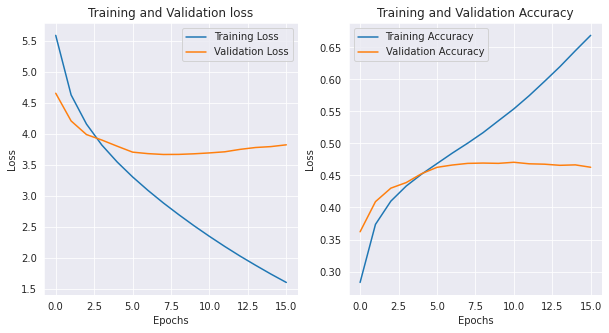

In [ ]:
model_name_de_en = 'encoder_decoder_de_en'
source_train = [encoder_input_train, decoder_input_train]
source_val = [encoder_input_val, decoder_input_val]
source_test = [encoder_input_test, decoder_input_test]
test_acc = model_de_en.evaluate(source_test, decoder_target_test, verbose=0)
val_acc = model_de_en.evaluate(source_val, decoder_target_val, verbose=0)
train_acc = model_de_en.evaluate(source_train, decoder_target_train, verbose=0)
test_accuracy = '{:.2%}'.format(test_acc[1])
val_accuracy = '{:.2%}'.format(val_acc[1])
train_accuracy = '{:.2%}'.format(train_acc[1])
print('Printing accuracy details for',model_name_de_en)
print('Test Accuracy:',test_accuracy)
print('Validation Accuracy:',val_accuracy)
print('Train Accuracy:',train_accuracy)
sacreblue_acc = corpus_accuracy(df_predict_encoder_decoder_de_en)
sacrebleu_score = round(sacreblue_acc,2)
meteor_avg_de_en = round(df_predict_encoder_decoder_de_en['METEOR'].mean(),2)
meteor_max_de_en = round(df_predict_encoder_decoder_de_en['METEOR'].max(),2)
df_summary.loc[len(df_summary.index)] = [model_name_de_en,test_accuracy,val_accuracy,train_accuracy,sacrebleu_score,meteor_avg_de_en,meteor_max_de_en]
plot_results(history)

In [ ]:
df_summary

Model Test Accuracy Validation Accuracy  \
0                 simple_RNN_en_de        24.72%              24.96%   
1                simple_LSTM_en_de        43.25%              43.18%   
2                simple_LSTM_de_en        40.12%              40.07%   
3            LSTM_with_GloVe_en_de        44.58%              44.38%   
4            LSTM_with_GloVe_de_en        42.33%              42.10%   
5         bidirectional_LSTM_de_en        42.72%              42.32%   
6         bidirectional_LSTM_en_de        42.96%              42.67%   
7   bidirectional_LSTM_GloVe_de_en        42.38%              42.05%   
8   bidirectional_LSTM_GloVe_en_de        42.43%              42.08%   
9            encoder_decoder_en_de        47.52%              47.01%   
10           encoder_decoder_de_en        46.50%              46.28%   

   Train Accuracy SacreBleu METEOR - Average METEOR - Max  
0          34.70%      5.57             0.35         0.68  
1          40.72%      3.86             0.31         0.52  
2          45.58%      6.78             0.29         0.69  
3          42.68%      7.69             0.28         0.72  
4          42.97%      3.55              0.3         0.57  
5          43.47%      6.39             0.45         0.89  
6          39.56%      5.27             0.27         0.71  
7          43.24%      5.96             0.46         0.89  
8          39.46%      7.69             0.33         0.77  
9          76.13%     17.01             0.37          1.0  
10         73.53%     10.18             0.31         0.83

In [ ]:
#Storing summary until milestone 2 in pickle file
summary_until_milestone2 = "/content/drive/MyDrive/Learning/summary_until_milestone2.pkl"
#function to save pickle file
def saveas_pickle_file(df, filename):
    df.to_pickle(filename)
    print('Saved: %s' % filename)
saveas_pickle_file(df_summary, summary_until_milestone2)

Saved: /content/drive/MyDrive/Learning/summary_until_milestone2.pkl


#### Encoder Decoder LSTM with Attention (German to English) - Observation

1.   Significant improvement has been observed in accuracy for Encoder/Decoder model with Attention mechanism.
2.   Train accuracy has reached more than 73% which indicates model has trained ~45% better than previous models
4.   Larger dataset and even complex models (with required computations capabilities) can be explored for better predictions.




#### Analysis on results from trained models

In [ ]:
#Summary of model performance highlighting the top values from metric
df_summary.style.apply(highlight_summary)

#### Pickling the best model

In [ ]:
pickle_location_en_de = '/content/drive/MyDrive/Learning/enc_dec_checkpoint.h5'
pickle_location_de_en = '/content/drive/MyDrive/Learning/enc_dec_checkpoint_de_en.h5'
model_weights_filename_en_de = '/content/drive/MyDrive/Learning/enc_dec_model.h5'
model_weights_filename_de_en = '/content/drive/MyDrive/Learning/enc_dec_model_de_en.h5'

In [ ]:
#Load the model for translation from english to german
model_to_load_en_de = pickle.load(open(pickle_location_en_de, 'rb'))
model_to_load_en_de.load_weights(model_weights_filename_en_de)
#Load the model for translation from german to english
model_to_load_de_en = pickle.load(open(pickle_location_de_en, 'rb'))
model_to_load_de_en.load_weights(model_weights_filename_de_en)

#### Conclusion: Encoder Decoder with GloVe & Attention is the best among all the models trained in this project